# **Data Exploration**

In [1]:
# libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import mutual_info_classif
import shap

C:\Users\kevin\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

In [2]:
def plot_correlation_matrix(df, title='Correlation Matrix', figsize=(10, 8), cmap='coolwarm'):
    """
    Plots a correlation matrix for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.
        cmap (str): The colormap to use.

    Returns:
        None
    """
    plt.figure(figsize=figsize)
    sns.heatmap(df.corr(),
            annot=True,
            cmap='coolwarm',
            center=0)
    plt.title(title)
    plt.show()

In [3]:
def plot_pairplot(df, hue=None, title='Pairplot', figsize=(10, 8)):
    """
    Plots a pairplot for the given DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        hue (str): The column name to use for color coding.
        title (str): The title of the plot.
        figsize (tuple): The size of the figure.

    Returns:
        None
    """
    sns.pairplot(df, hue=hue)
    plt.suptitle(title, y=1.02)
    plt.show()

In [4]:
def plot_feature_distributions(dataframe, n_cols=3, fig_width=15, row_height=4, 
                              kde=True, color='skyblue', title_prefix='Distribution of '):
    """
    Plots distribution histograms for all columns in a DataFrame in a grid layout.
    
    Parameters:
    -----------
    dataframe : pandas.DataFrame
        The DataFrame containing the data to plot
    n_cols : int (default=3)
        Number of columns in the subplot grid
    fig_width : int (default=15)
        Width of the entire figure in inches
    row_height : int (default=4)
        Height of each row in inches
    kde : bool (default=True)
        Whether to show kernel density estimate
    color : str (default='skyblue')
        Color for the histograms
    title_prefix : str (default='Distribution of ')
        Prefix for each subplot title
    """
    # Calculate grid dimensions
    n_features = len(dataframe.columns)
    n_rows = (n_features - 1) // n_cols + 1
    
    # Create figure and axes
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(fig_width, n_rows * row_height))
    fig.tight_layout(pad=3.0)
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot histograms for each feature
    for i, column in enumerate(dataframe.columns):
        sns.histplot(data=dataframe, x=column, kde=kde, color=color, ax=axes[i])
        axes[i].set_title(f'{title_prefix}{column}')
        axes[i].set_xlabel('')
        
        # Rotate x-tick labels if they're too long
        if len(dataframe[column].unique()) < 10:  # For categorical features
            axes[i].tick_params(axis='x', rotation=45)
    
    # Hide any empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.show()

In [5]:
# Feature importance function: capture the trained models during our initial
# training phase and then use them for feature importance analysis
def plot_feature_importance(model, feature_names, title):
    importances = pd.DataFrame({
        'feature': feature_names,
        'importance': model.feature_importances_
    })
    importances = importances.sort_values('importance', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(data=importances, x='importance', y='feature')
    plt.title(title)
    plt.xlabel('Feature Importance')
    plt.tight_layout()
    plt.show()

In [6]:
def test_feature_engineering(df, new_feature, target='AccumulationInvestment', baseline_features=None, threshold_corr=0.1, threshold_mi=0.01, threshold_auc=0.01):
    """
    Tests the relevance of a newly engineered feature for predicting a target variable.
    
    Parameters:
    - df: DataFrame containing the data
    - new_feature: Name of the new feature column to test
    - target: Name of the target column (default: 'AccumulationInvestment')
    - baseline_features: List of existing features to compare against (if None, uses all non-target columns except new_feature)
    - threshold_corr: Minimum absolute correlation to consider (default: 0.1)
    - threshold_mi: Minimum mutual information to consider (default: 0.01)
    - threshold_auc: Minimum AUC improvement to consider (default: 0.01)
    
    Returns:
    - Dictionary containing test results and recommendations
    """
    
    results = {
        'new_feature': new_feature,
        'keep_feature': False,
        'recommendation': '',
        'details': {}
    }
    
    # 1. Correlation Check
    corr = df[new_feature].corr(df[target])
    results['details']['correlation_with_target'] = corr
    
    # 2. Mutual Information (Non-linear check)
    mi = mutual_info_classif(df[[new_feature]], df[target])[0]
    results['details']['mutual_information'] = mi
    
    # 3. Set baseline features if not provided
    if baseline_features is None:
        baseline_features = [col for col in df.columns if col not in [target, new_feature]]
    
    # 4. Model Performance Test
    X_base = df[baseline_features]
    X_new = X_base.join(df[[new_feature]])
    y = df[target]
    
    # Baseline score (without new feature)
    base_score = cross_val_score(RandomForestClassifier(random_state=42), 
                               X_base, y, cv=5, scoring='roc_auc').mean()
    
    # Score with new feature
    new_score = cross_val_score(RandomForestClassifier(random_state=42), 
                              X_new, y, cv=5, scoring='roc_auc').mean()
    
    results['details']['auc_base'] = base_score
    results['details']['auc_with_new_feature'] = new_score
    results['details']['auc_improvement'] = new_score - base_score
    
    # 5. SHAP Analysis
    model = RandomForestClassifier(random_state=42).fit(X_new, y)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_new)
    
    # Get SHAP importance for the new feature
    feature_idx = list(X_new.columns).index(new_feature)
    shap_importance = np.abs(shap_values).mean(axis=0)[feature_idx]
    results['details']['shap_importance'] = shap_importance

    print("="*50)
    print(f"Feature Engineering Test Results for {new_feature}:")

    # 8. Plot correlation of the new feature and target
    plot_correlation_matrix(df, title=f'Correlation Matrix with {new_feature}')

    # 9. Shap plots
    plot_feature_importance(model, X_new.columns, f"Feature Importance with {new_feature}")
    
    
    return results

In [ ]:
def create_variable_summary(df, metadata_df):
    # Create empty lists to store the chosen statistics
    stats_dict = {
        'Variable': [],
        'Description': [],
        'Mean': [],
        'Std': [],
        'Missing': [],
        'Min': [],
        'Max': []
    }

    # Create a metadata dictionary for easy lookup
    meta_dict = dict(zip(metadata_df['Metadata'], metadata_df['Unnamed: 1']))

    for col in df.columns:
        stats_dict['Variable'].append(col)
        stats_dict['Description'].append(meta_dict.get(col, 'N/A'))

        # Calculate some statistics for each column
        if pd.api.types.is_numeric_dtype(df[col]):
            stats_dict['Mean'].append(f"{df[col].mean():.2f}")
            stats_dict['Std'].append(f"{df[col].std():.2f}")
            stats_dict['Min'].append(f"{df[col].min():.2f}")
            stats_dict['Max'].append(f"{df[col].max():.2f}")
        else:
            stats_dict['Mean'].append('N/A')
            stats_dict['Std'].append('N/A')
            stats_dict['Min'].append('N/A')
            stats_dict['Max'].append('N/A')

        stats_dict['Missing'].append(df[col].isna().sum())

    return pd.DataFrame(stats_dict)

## Import the data

In [7]:
# Load each sheet into separate DataFrames
# Define the file path in Google Drive
file_path = 'Dataset2_Needs.xls'

# Load each sheet into separate DataFrames
needs_df = pd.read_excel(file_path, sheet_name='Needs')
products_df = pd.read_excel(file_path, sheet_name='Products')
metadata_df = pd.read_excel(file_path, sheet_name='Metadata')

In [8]:
needs_df.head()

ID  Age  Gender  FamilyMembers  FinancialEducation  RiskPropensity  \
0   1   60       0              2            0.228685        0.233355   
1   2   78       0              2            0.358916        0.170911   
2   3   33       1              2            0.317515        0.249703   
3   4   69       1              4            0.767685        0.654597   
4   5   58       0              3            0.429719        0.349039   

       Income      Wealth  IncomeInvestment  AccumulationInvestment  
0   68.181525   53.260067                 0                       1  
1   21.807595  135.550048                 1                       0  
2   23.252747   66.303678                 0                       1  
3  166.189034  404.997689                 1                       1  
4   21.186723   58.911930                 0                       0

In [9]:
products_df.head()

IDProduct  Type  Risk
0          1     1  0.55
1          2     0  0.30
2          3     0  0.12
3          4     0  0.44
4          5     1  0.41

In [10]:
metadata_df.head()

Metadata                     Unnamed: 1
0        Clients                            NaN
1             ID                   Numerical ID
2            Age                  Age, in years
3         Gender  Gender (Female = 1, Male = 0)
4  FamilyMembers           Number of components

In [11]:
# Drop ID column as it's not needed for analysis
needs_df = needs_df.drop('ID', axis=1)

## First Insight

In [ ]:
# Create summary tables
print("NEEDS VARIABLES SUMMARY:")
needs_summary = create_variable_summary(needs_df, metadata_df)
display(needs_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))

print("\nPRODUCTS VARIABLES SUMMARY:")
products_summary = create_variable_summary(products_df, metadata_df)
display(products_summary.style
        .set_properties(**{'text-align': 'left'})
        .hide(axis='index'))


NEEDS VARIABLES SUMMARY:



PRODUCTS VARIABLES SUMMARY:


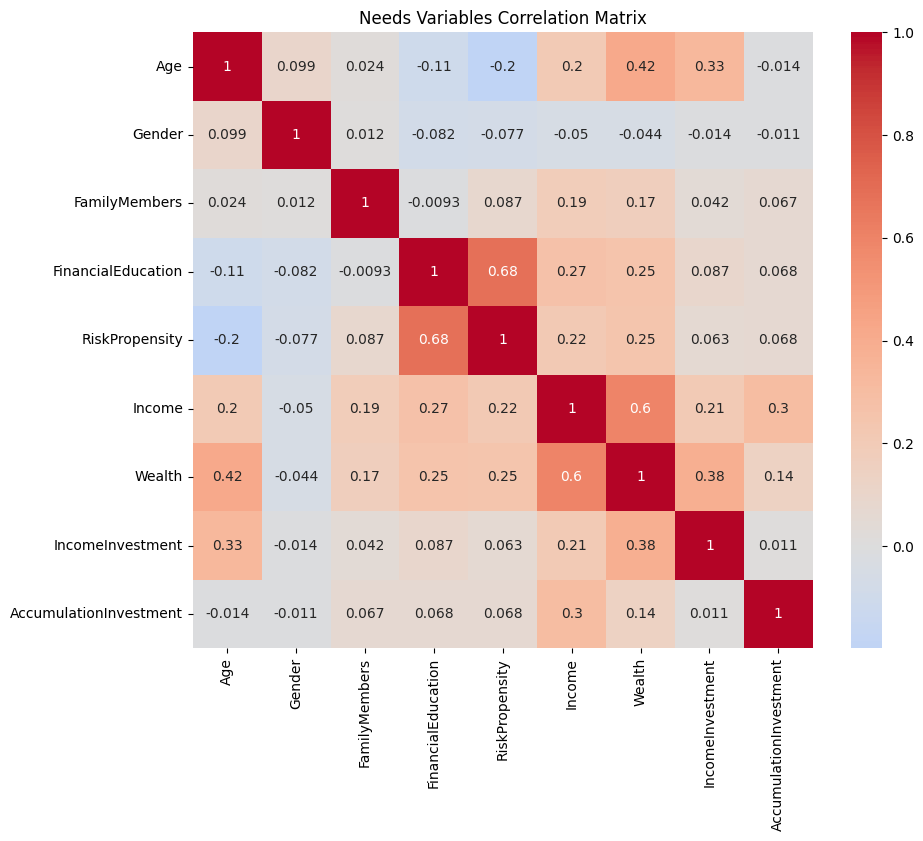

In [13]:
plot_correlation_matrix(needs_df, title='Needs Variables Correlation Matrix')

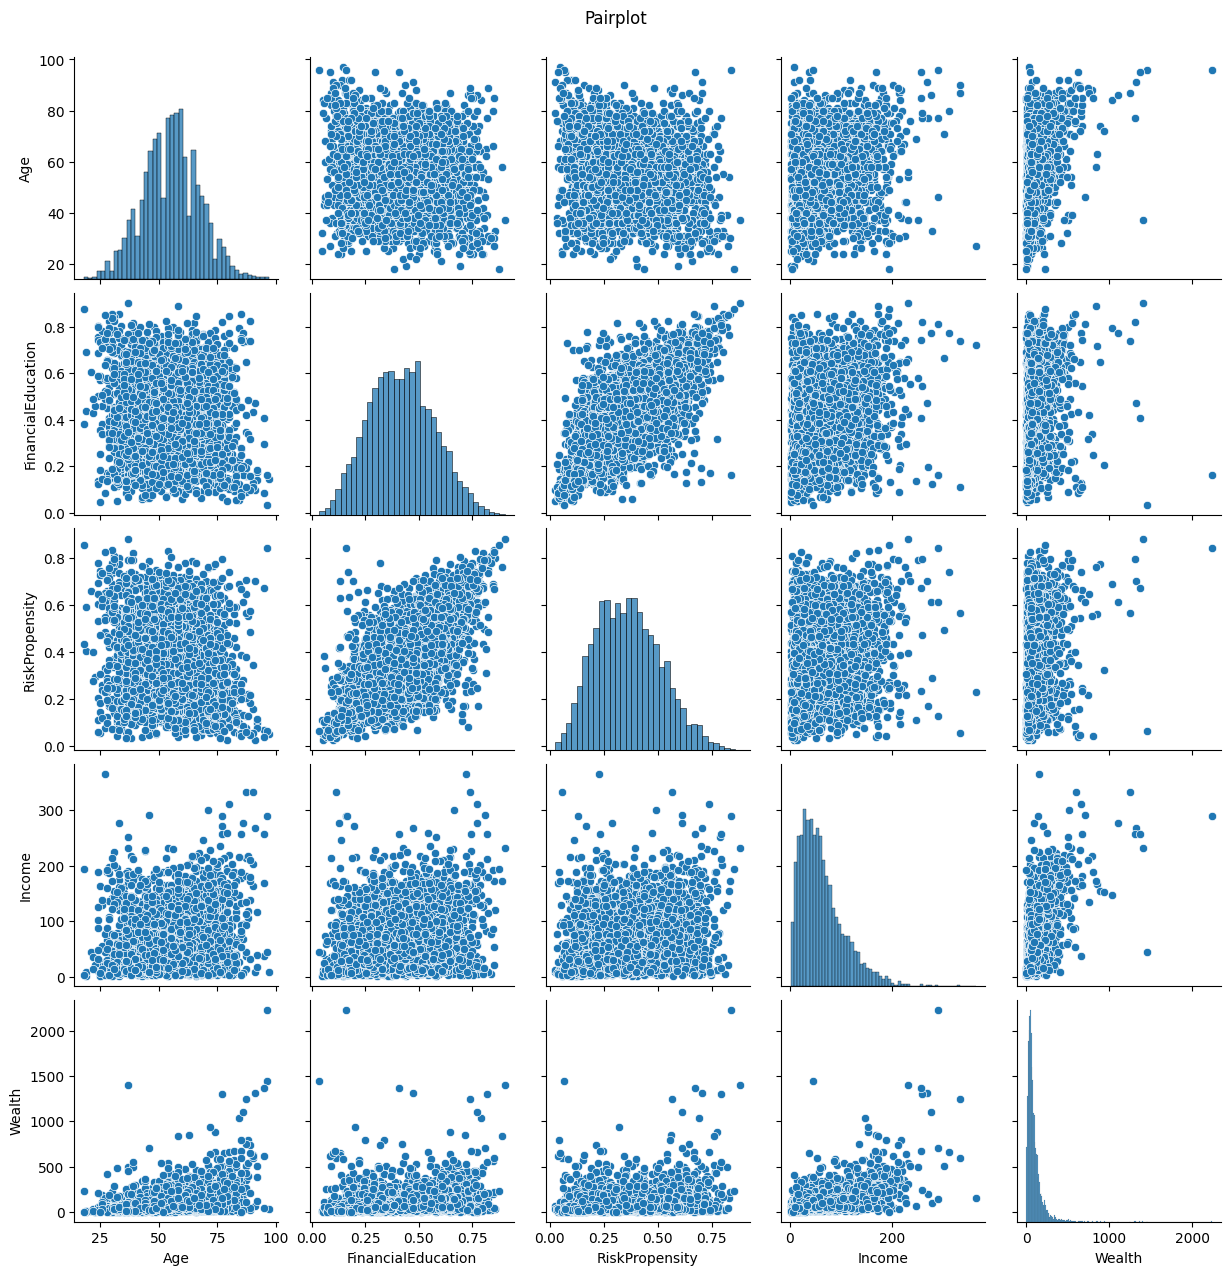

In [14]:
plot_pairplot(needs_df[["Age", "FinancialEducation", "RiskPropensity", "Income", "Wealth"]], hue=None, title='Pairplot', figsize=(10, 8))

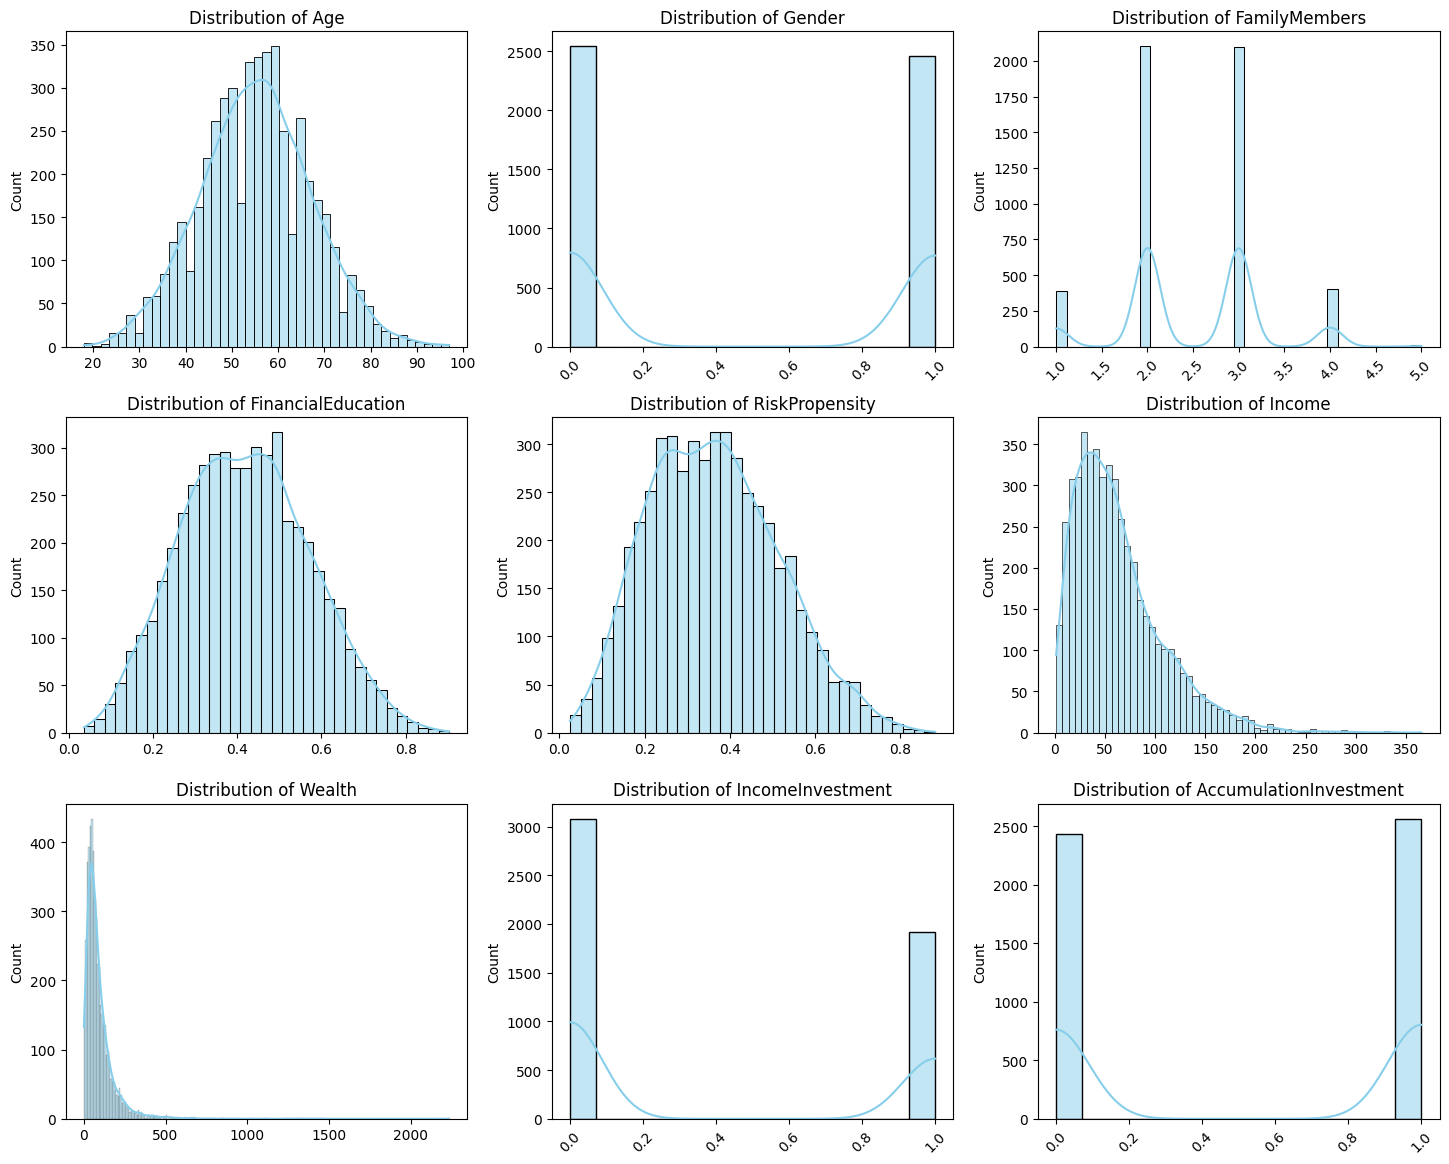

In [15]:
plot_feature_distributions(needs_df)

# Encoding

In [16]:
needs_df["Wealth_log"] = np.log1p(needs_df["Wealth"])
needs_df["Income_log"] = np.sqrt(needs_df["Income"])
needs_df = needs_df.drop(columns=["Wealth", "Income", "Gender"])

In [17]:
Standard_Scaler_features = ["Age", "RiskPropensity", "FinancialEducation", "Wealth_log", "Income_log"]

# 2. Initialize StandardScaler
scaler = StandardScaler()
needs_df[Standard_Scaler_features] = scaler.fit_transform(needs_df[Standard_Scaler_features])

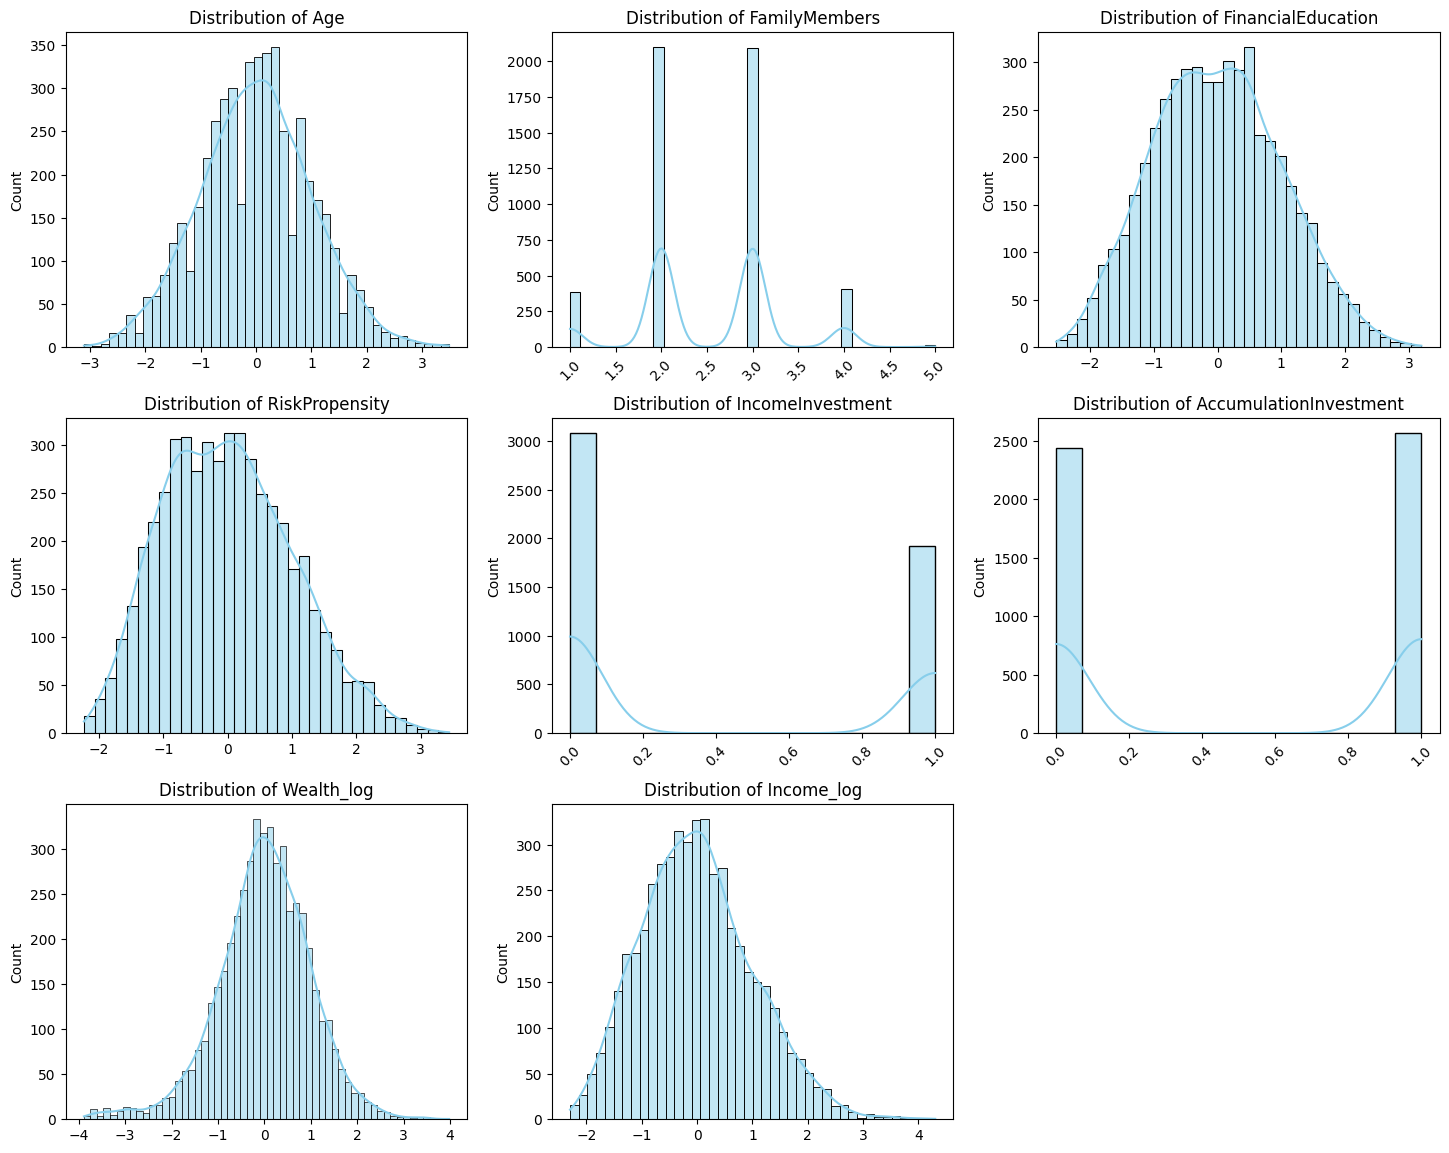

In [18]:
plot_feature_distributions(needs_df)

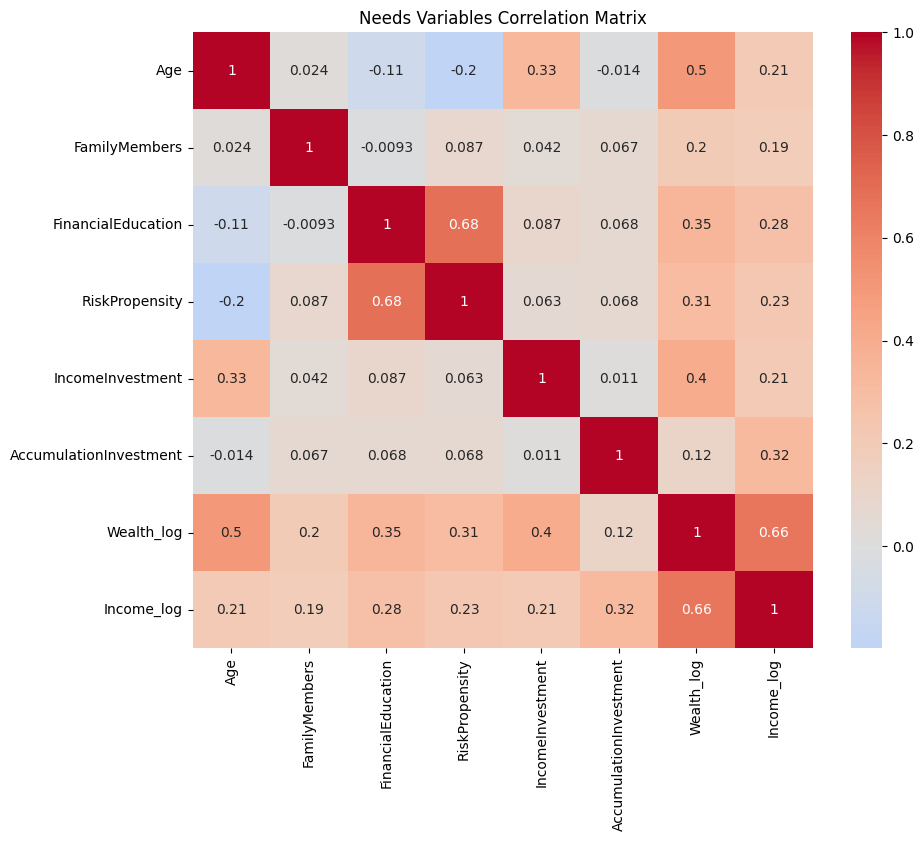

In [19]:
plot_correlation_matrix(needs_df, title='Needs Variables Correlation Matrix')

# Data preparation

## Accumulation Investment

In [20]:
df_accumulation = needs_df.copy()
df_accumulation = df_accumulation.drop(columns=['IncomeInvestment'])
df_accumulation.head()

Age  FamilyMembers  FinancialEducation  RiskPropensity  \
0  0.396525              2           -1.258110       -0.855883   
1  1.900222              2           -0.397747       -1.269115   
2 -1.859021              2           -0.671259       -0.747694   
3  1.148373              4            2.302746        1.931786   
4  0.229447              3            0.070007       -0.090315   

   AccumulationInvestment  Wealth_log  Income_log  
0                       1   -0.205413    0.294165  
1                       0    0.833019   -1.030406  
2                       1    0.036981   -0.974190  
3                       1    2.059078    2.005276  
4                       0   -0.093922   -1.055129

In [21]:
df_accumulation.corr(numeric_only=True)[['AccumulationInvestment']]

AccumulationInvestment
Age                                  -0.013512
FamilyMembers                         0.066606
FinancialEducation                    0.067965
RiskPropensity                        0.068420
AccumulationInvestment                1.000000
Wealth_log                            0.119486
Income_log                            0.320306

In [22]:
feature_combinations = {
    # Multiplicative interactions
    'Age * RiskPropensity': lambda df: df['Age'] * df['RiskPropensity'],
    'Age * FinancialEducation': lambda df: df['Age'] * df['FinancialEducation'],
    'Age * Wealth_log': lambda df: df['Age'] * df['Wealth_log'],
    'RiskPropensity * FinancialEducation': lambda df: df['RiskPropensity'] * df['FinancialEducation'],
    'RiskPropensity * Wealth_log': lambda df: df['RiskPropensity'] * df['Wealth_log'],
    'FinancialEducation * Wealth_log': lambda df: df['FinancialEducation'] * df['Wealth_log'],
    'FinancialEducation * Income_log': lambda df: df['FinancialEducation'] * df['Income_log'],
    'Income_log * Wealth_log': lambda df: df['Income_log'] * df['Wealth_log'],
    
    # Ratio interactions (with epsilon to avoid division by zero)
    'Income / Wealth': lambda df: df['Income_log'] / df['Wealth_log'],
    'Age / Wealth': lambda df: df['Age'] / (df['Wealth_log']),
    'Edu / Risk': lambda df: df['FinancialEducation'] / (df['RiskPropensity']),
    'Wealth / Family': lambda df: (df['Wealth_log']) / df['FamilyMembers'],
    'Income / Family': lambda df: (df['Income_log']) / df['FamilyMembers']
}


# Create the two lists
datasets_with_new_features = []
new_feature_names = []

# Generate datasets
for feature_name, creation_func in feature_combinations.items():
    # Copy original data to avoid modifying it
    df_copy = df_accumulation.copy()
    # Add the new feature
    df_copy[feature_name] = creation_func(df_copy)
    # Append to lists
    datasets_with_new_features.append(df_copy)
    new_feature_names.append(feature_name)

# Verification
print("New feature names:", new_feature_names)
print("\nFirst dataset with feature", new_feature_names[0], ":")
datasets_with_new_features[1].head()

New feature names: ['Age * RiskPropensity', 'Age * FinancialEducation', 'Age * Wealth_log', 'RiskPropensity * FinancialEducation', 'RiskPropensity * Wealth_log', 'FinancialEducation * Wealth_log', 'FinancialEducation * Income_log', 'Income_log * Wealth_log', 'Income / Wealth', 'Age / Wealth', 'Edu / Risk', 'Wealth / Family', 'Income / Family']

First dataset with feature Age * RiskPropensity :


Age  FamilyMembers  FinancialEducation  RiskPropensity  \
0  0.396525              2           -1.258110       -0.855883   
1  1.900222              2           -0.397747       -1.269115   
2 -1.859021              2           -0.671259       -0.747694   
3  1.148373              4            2.302746        1.931786   
4  0.229447              3            0.070007       -0.090315   

   AccumulationInvestment  Wealth_log  Income_log  Age * FinancialEducation  
0                       1   -0.205413    0.294165                 -0.498872  
1                       0    0.833019   -1.030406                 -0.755808  
2                       1    0.036981   -0.974190                  1.247884  
3                       1    2.059078    2.005276                  2.644413  
4                       0   -0.093922   -1.055129                  0.016063

Feature Engineering Test Results for Age * RiskPropensity:


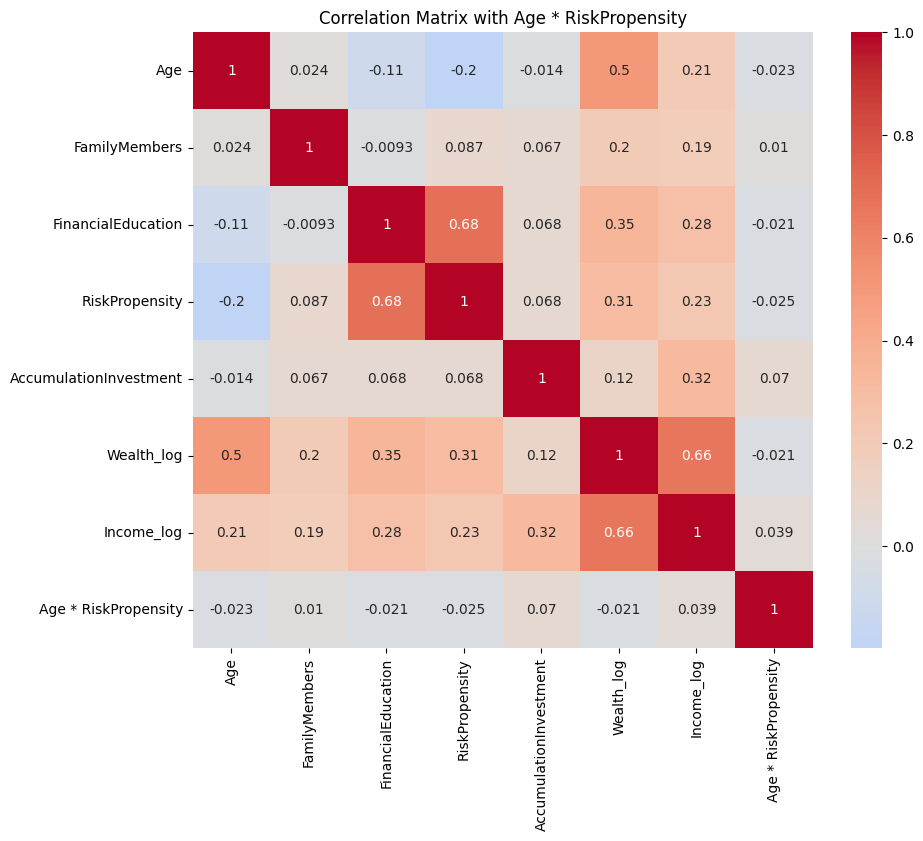

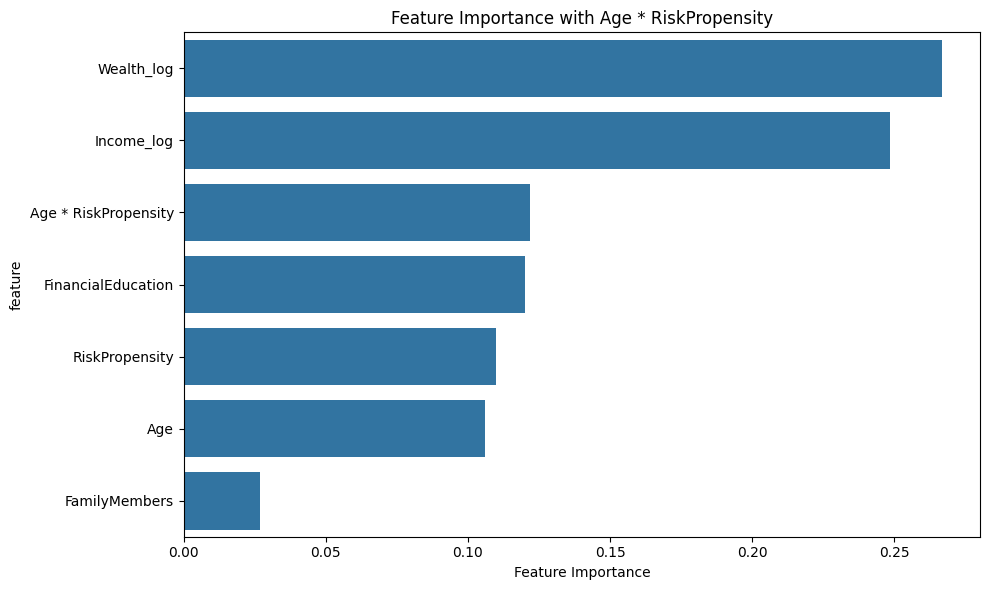

Results for Age * RiskPropensity: {'new_feature': 'Age * RiskPropensity', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.07011757092994444, 'mutual_information': 0.0012568265264738532, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8488699357739458, 'auc_improvement': -0.0008454031829970843, 'shap_importance': array([0.04357276, 0.04357276])}}
Feature Engineering Test Results for Age * FinancialEducation:


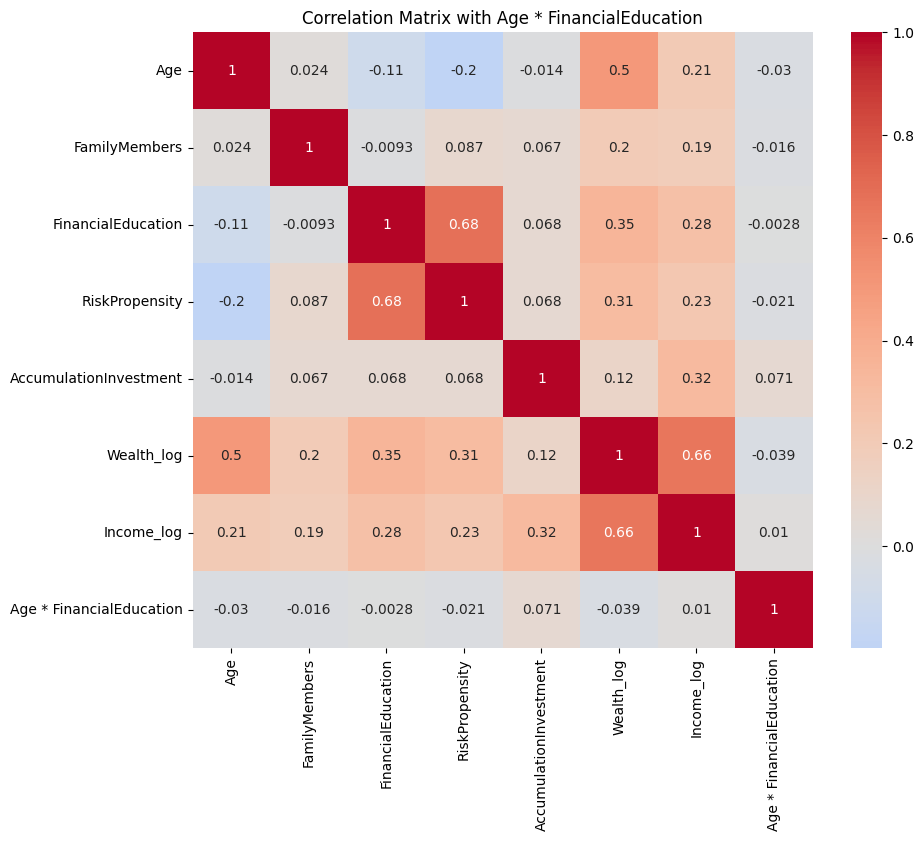

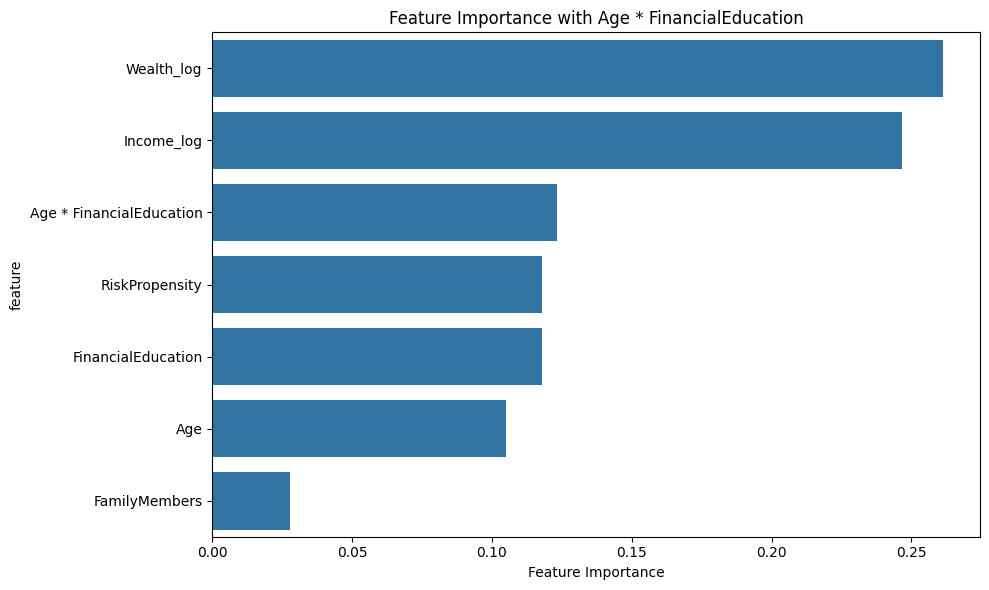

Results for Age * FinancialEducation: {'new_feature': 'Age * FinancialEducation', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.07142795048310817, 'mutual_information': 0.009236308082069877, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8462878356266025, 'auc_improvement': -0.0034275033303403646, 'shap_importance': array([0.04834007, 0.04834007])}}
Feature Engineering Test Results for Age * Wealth_log:


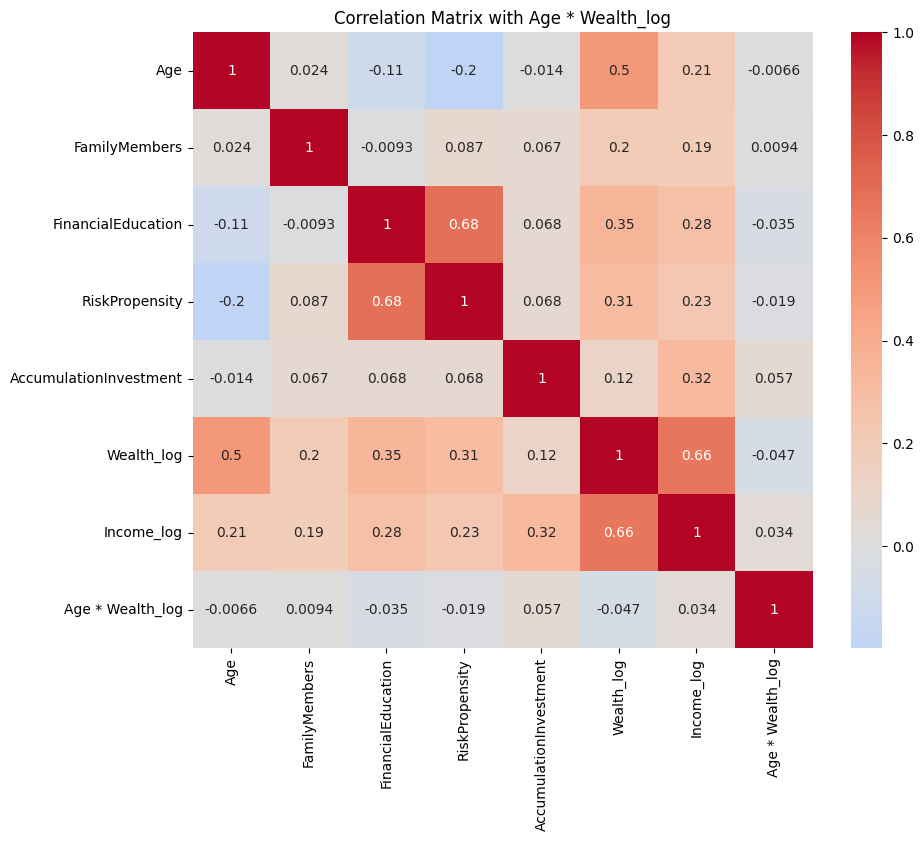

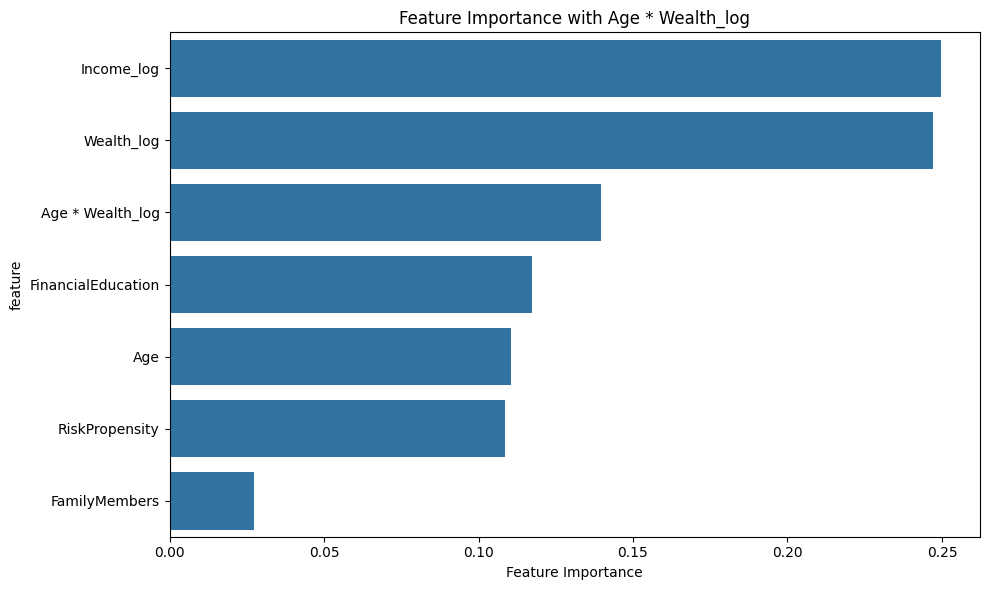

Results for Age * Wealth_log: {'new_feature': 'Age * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.056730067741585795, 'mutual_information': 0.023707401999071065, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8508234509892283, 'auc_improvement': 0.0011081120322854465, 'shap_importance': array([0.05477826, 0.05477826])}}
Feature Engineering Test Results for RiskPropensity * FinancialEducation:


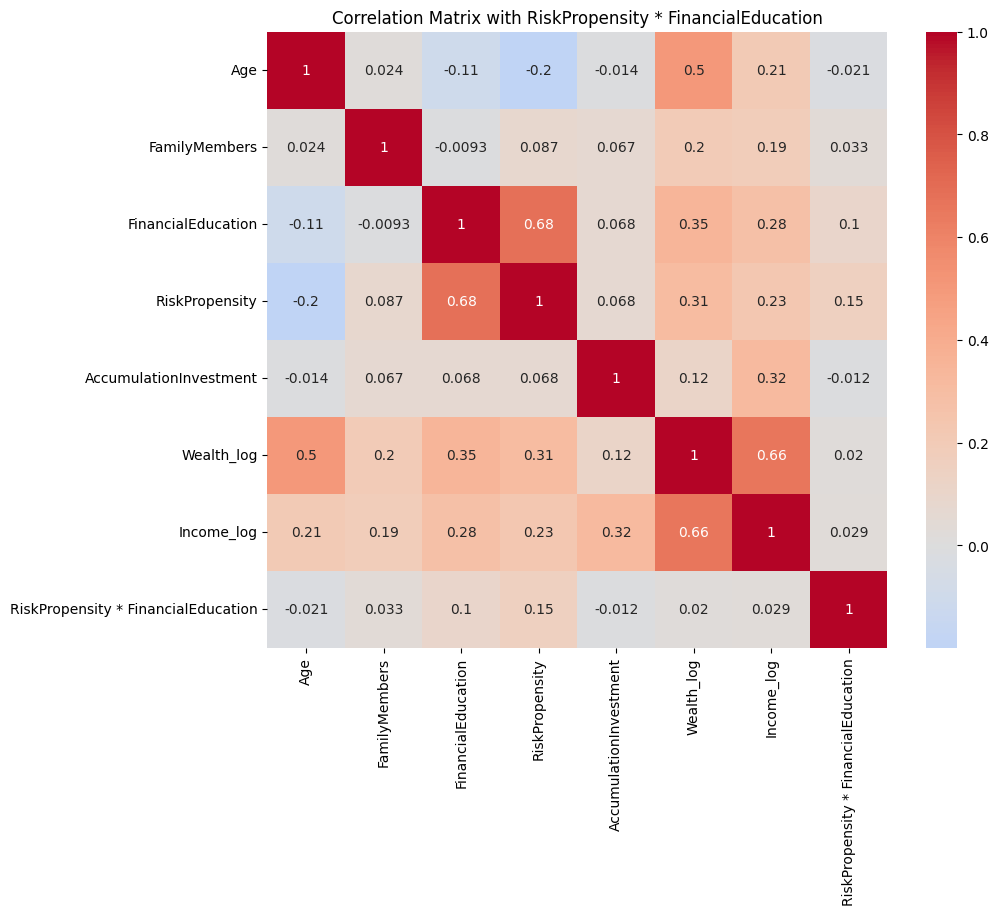

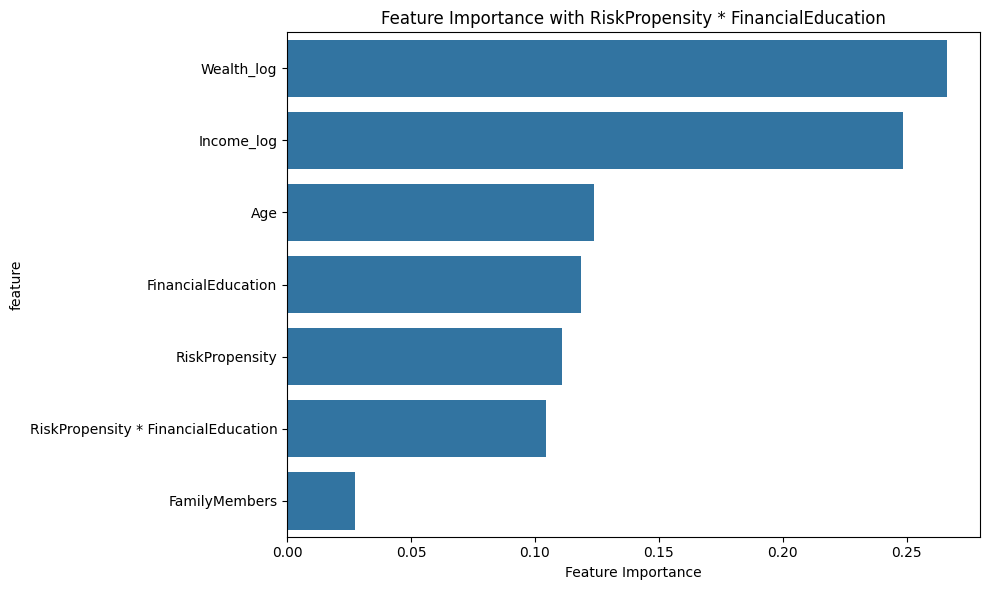

Results for RiskPropensity * FinancialEducation: {'new_feature': 'RiskPropensity * FinancialEducation', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -0.012414745063783624, 'mutual_information': 0.004442214940949096, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8445529884211238, 'auc_improvement': -0.005162350535819038, 'shap_importance': array([0.02831041, 0.02831041])}}
Feature Engineering Test Results for RiskPropensity * Wealth_log:


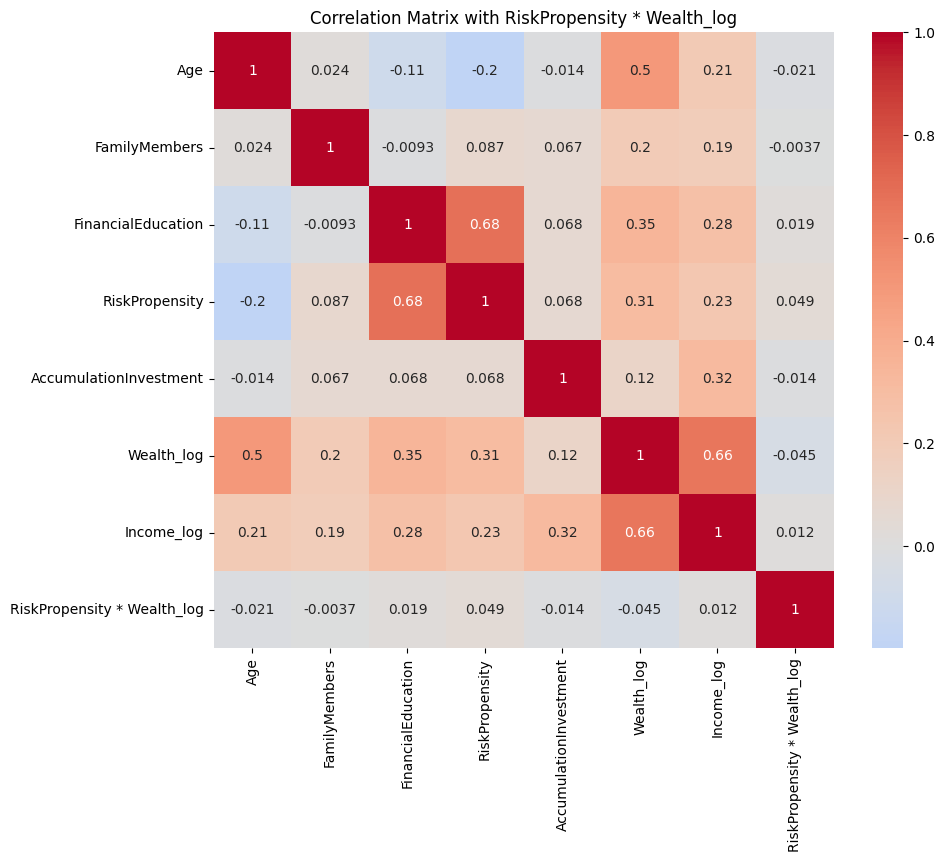

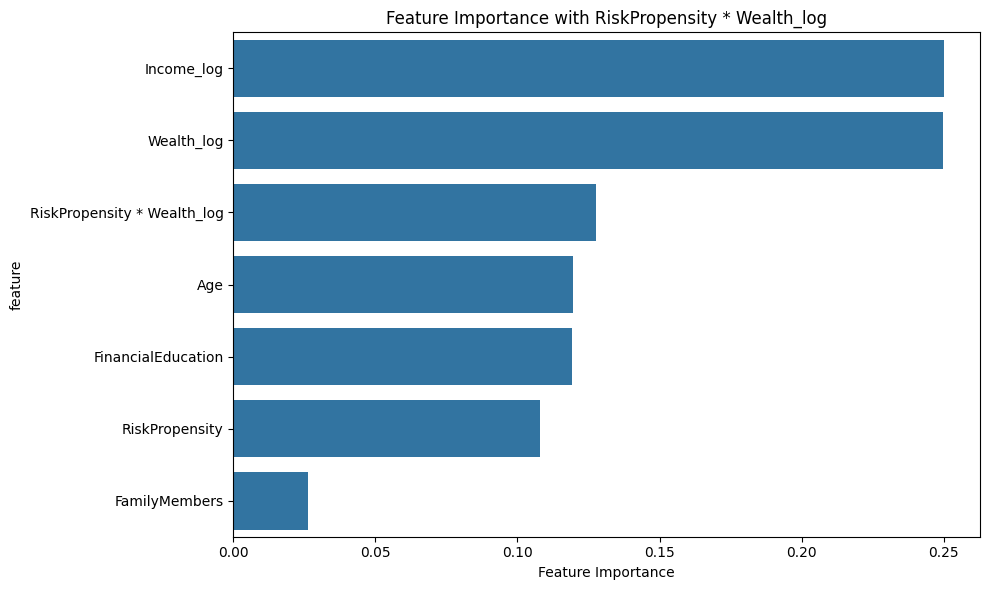

Results for RiskPropensity * Wealth_log: {'new_feature': 'RiskPropensity * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -0.013720838459334212, 'mutual_information': 0.006234925665896451, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8474610531920617, 'auc_improvement': -0.002254285764881181, 'shap_importance': array([0.03684661, 0.03684661])}}
Feature Engineering Test Results for FinancialEducation * Wealth_log:


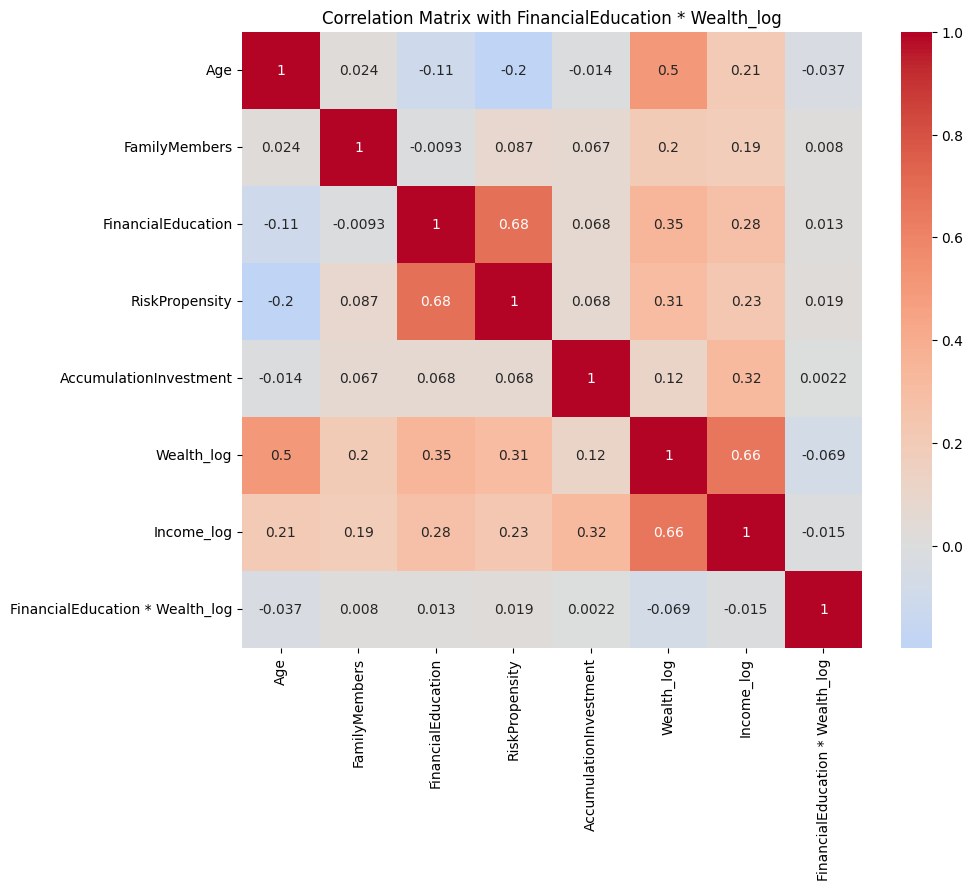

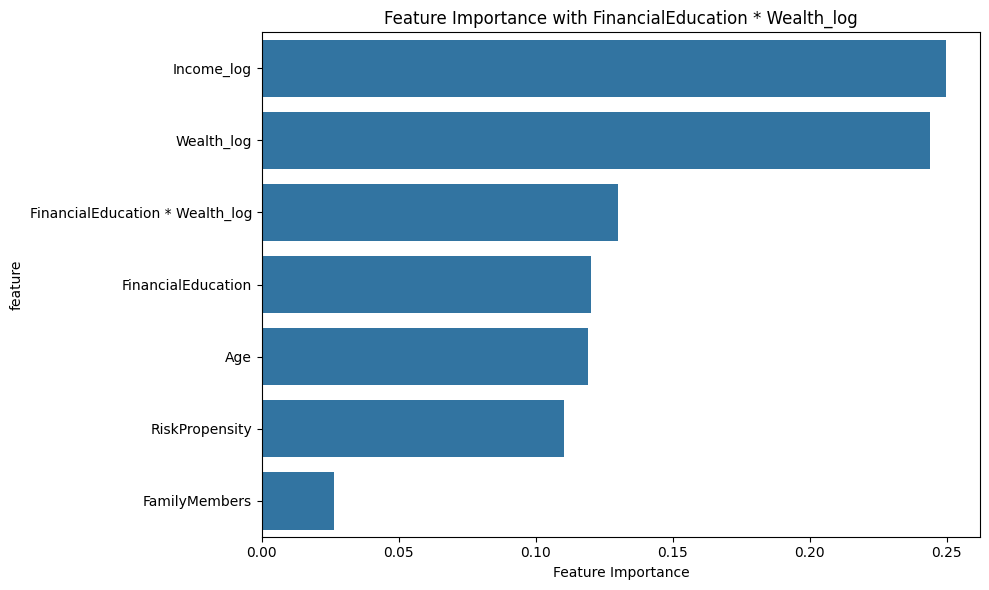

Results for FinancialEducation * Wealth_log: {'new_feature': 'FinancialEducation * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.002202441006164676, 'mutual_information': 0.0034118378713381414, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.845862754454177, 'auc_improvement': -0.003852584502765821, 'shap_importance': array([0.04185393, 0.04185393])}}
Feature Engineering Test Results for FinancialEducation * Income_log:


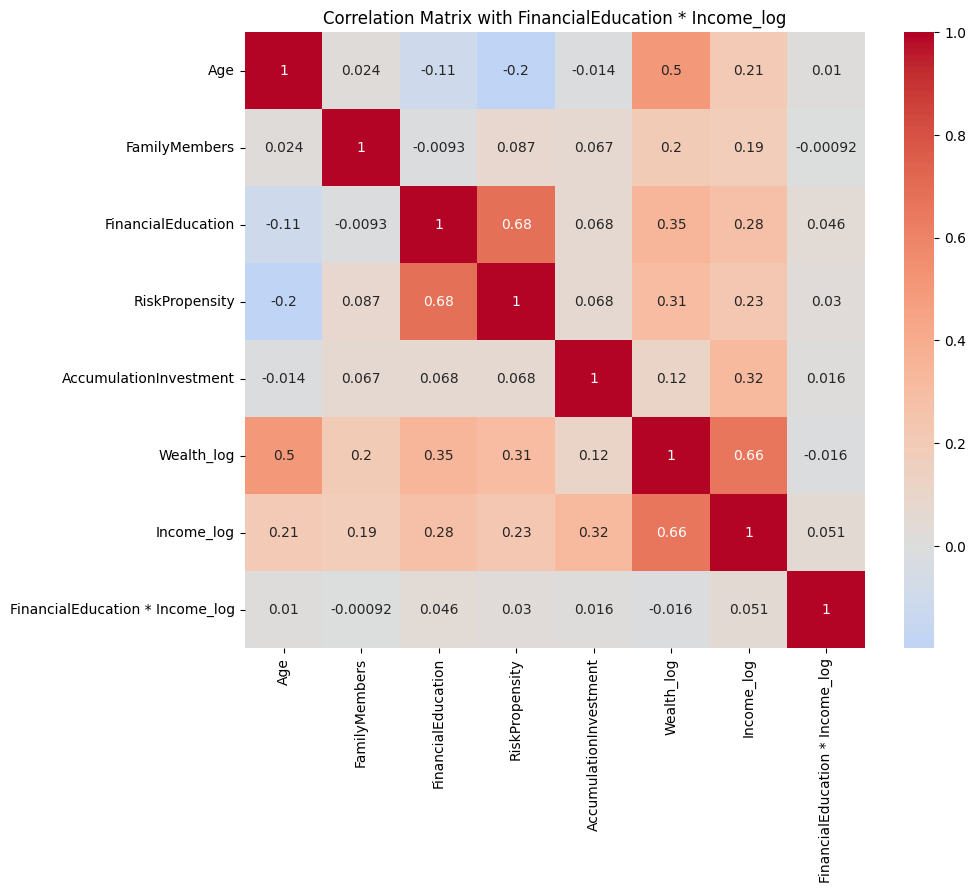

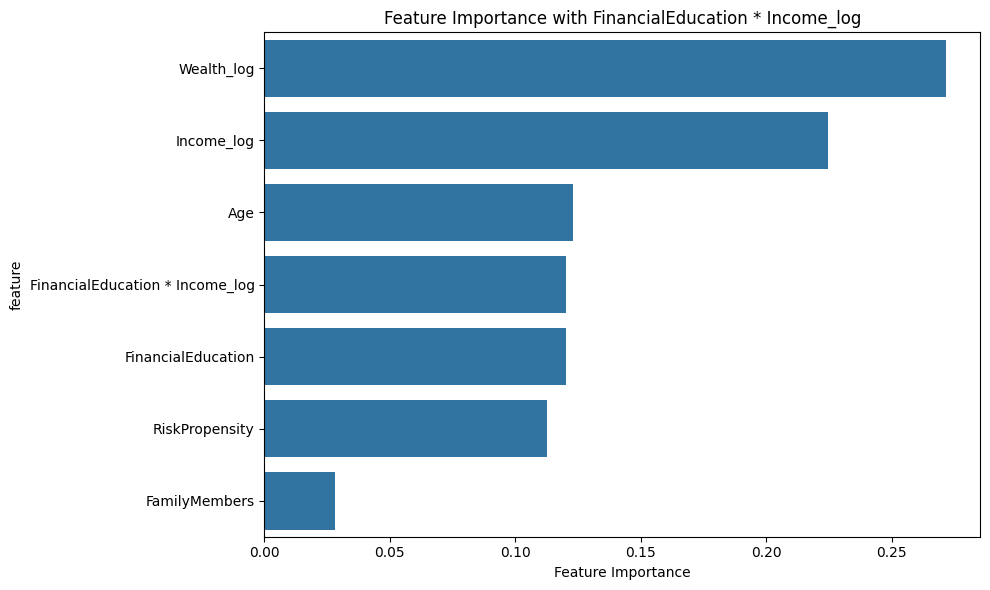

Results for FinancialEducation * Income_log: {'new_feature': 'FinancialEducation * Income_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.016029234402909952, 'mutual_information': 0.009966148694673826, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8464370383034355, 'auc_improvement': -0.0032783006535073156, 'shap_importance': array([0.03725649, 0.03725649])}}
Feature Engineering Test Results for Income_log * Wealth_log:


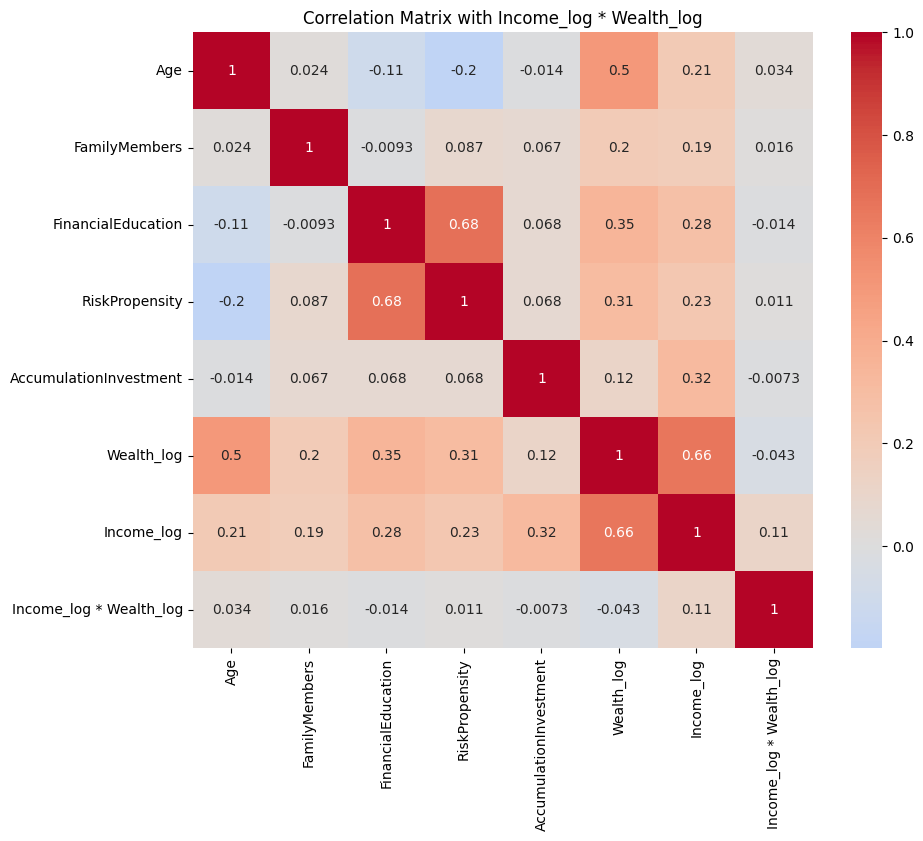

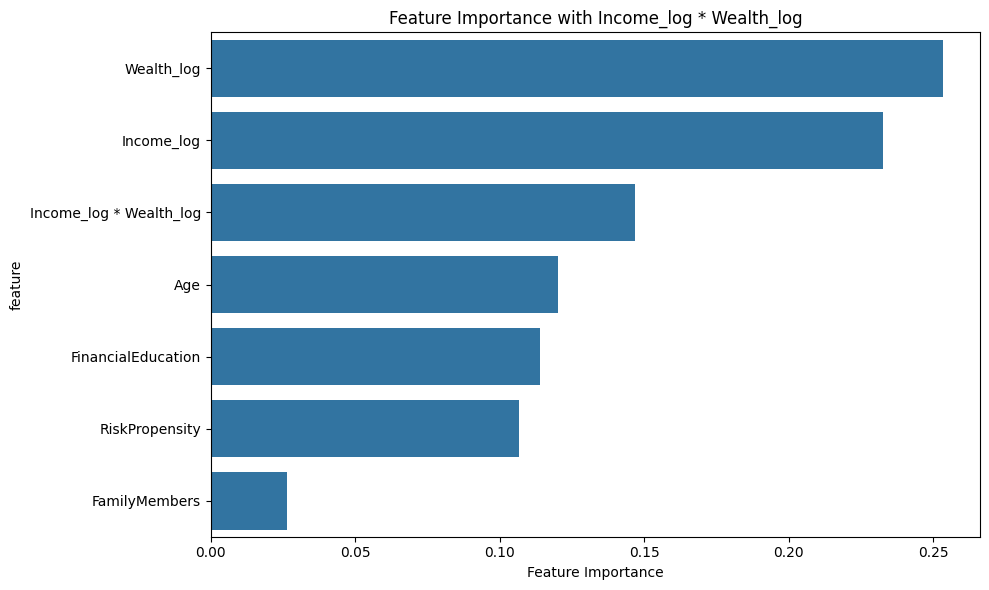

Results for Income_log * Wealth_log: {'new_feature': 'Income_log * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -0.007307367339313786, 'mutual_information': 0.0017603383947226714, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8500512121810427, 'auc_improvement': 0.00033587322409989184, 'shap_importance': array([0.05065808, 0.05065808])}}
Feature Engineering Test Results for Income / Wealth:


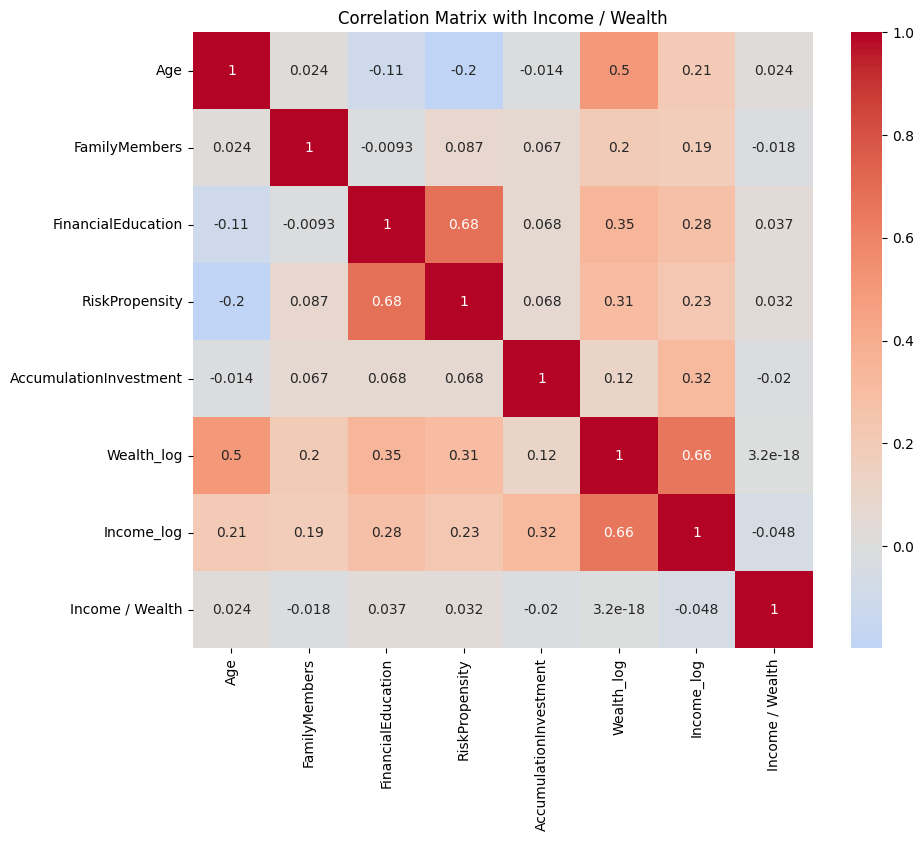

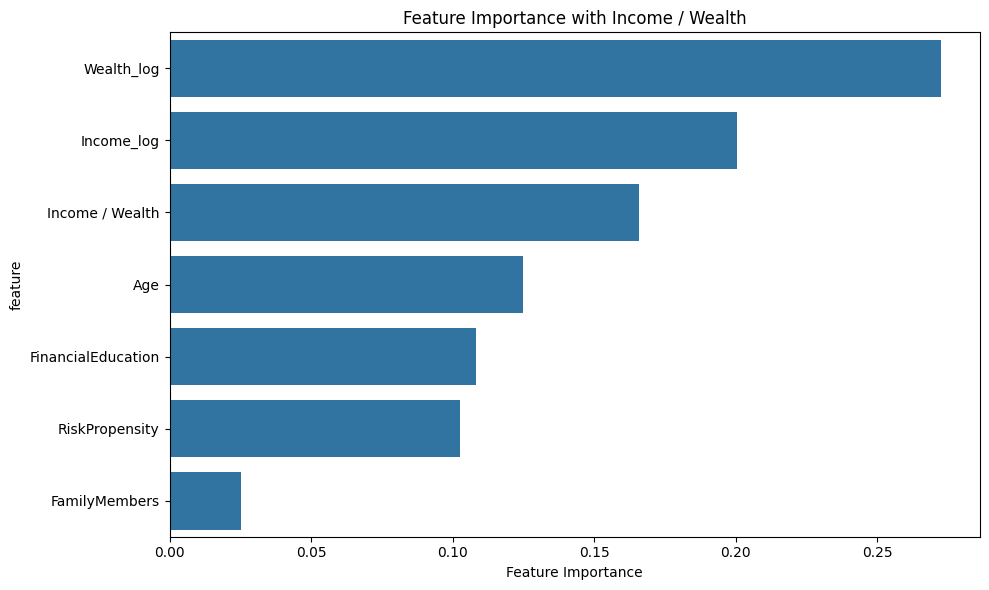

Results for Income / Wealth: {'new_feature': 'Income / Wealth', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -0.020306211520247006, 'mutual_information': 0.013157303618597238, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8623131400683326, 'auc_improvement': 0.01259780111138975, 'shap_importance': array([0.08657202, 0.08657202])}}
Feature Engineering Test Results for Age / Wealth:


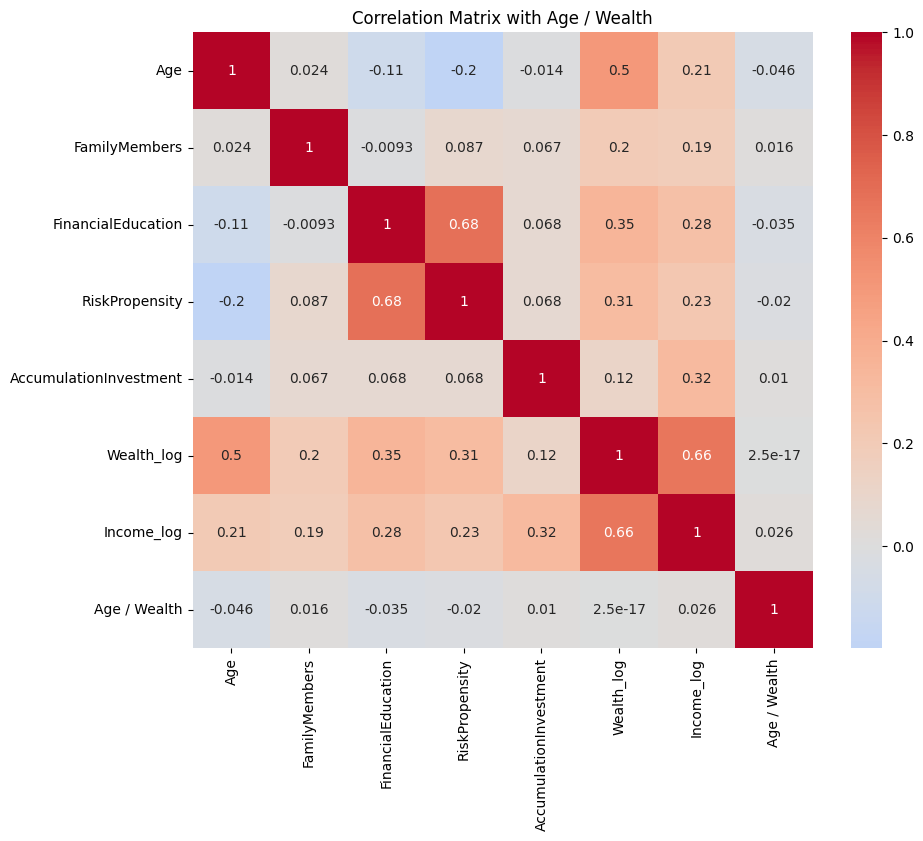

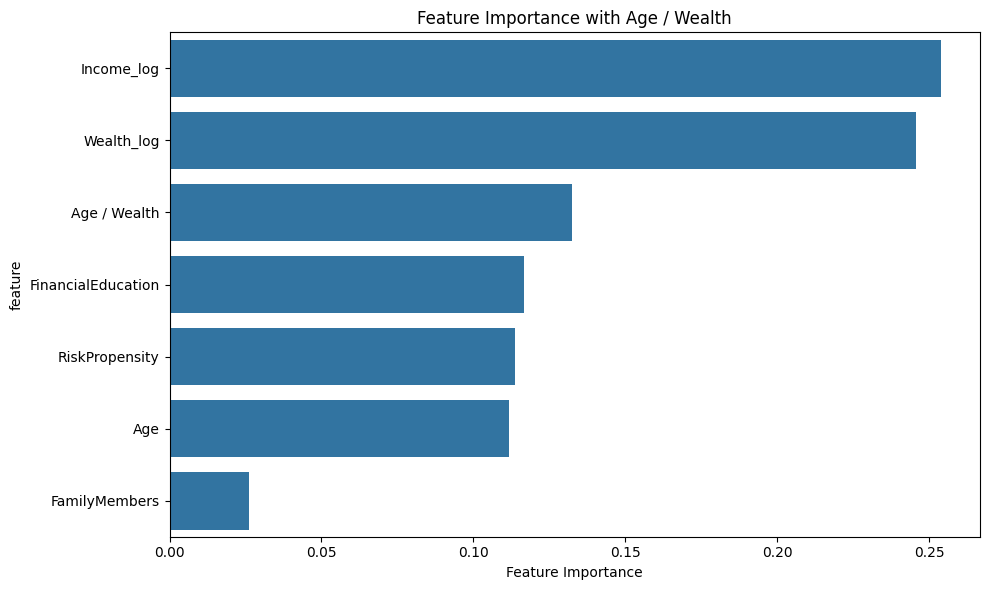

Results for Age / Wealth: {'new_feature': 'Age / Wealth', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.010124507173636565, 'mutual_information': 0.010030040712827315, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8512357065871126, 'auc_improvement': 0.0015203676301697167, 'shap_importance': array([0.05183175, 0.05183175])}}
Feature Engineering Test Results for Edu / Risk:


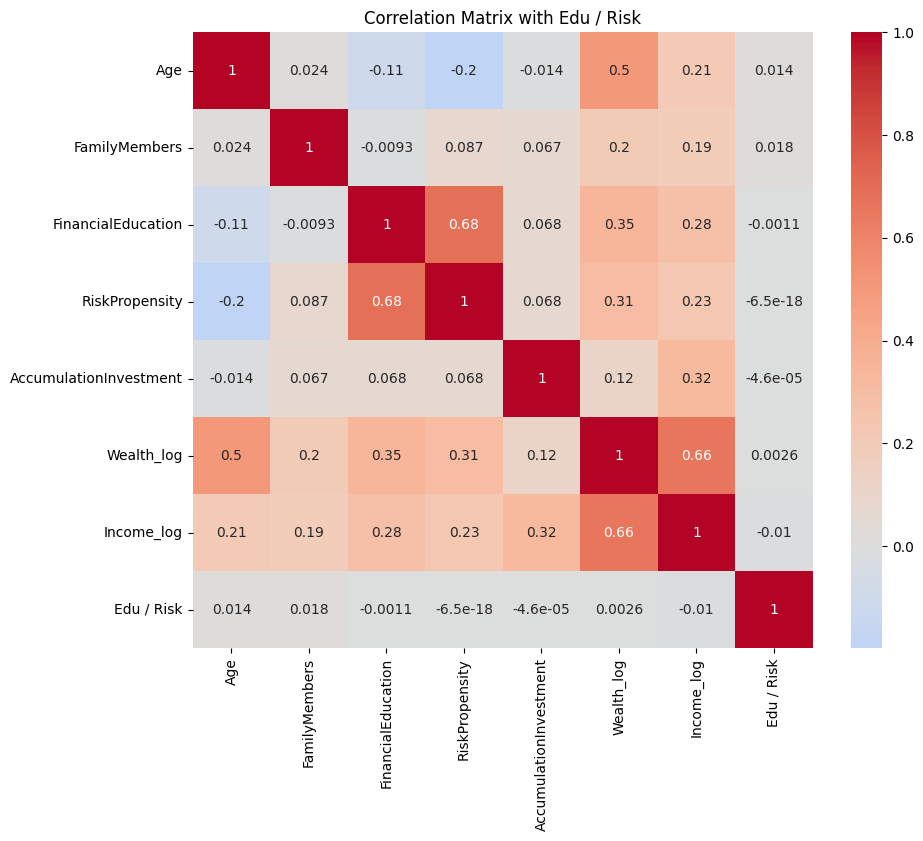

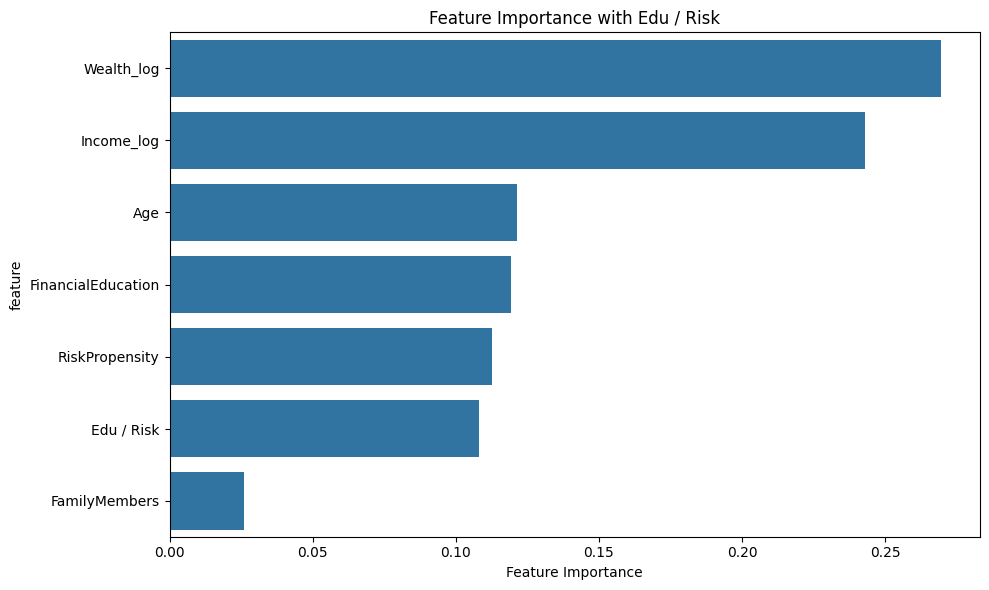

Results for Edu / Risk: {'new_feature': 'Edu / Risk', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -4.597507707206111e-05, 'mutual_information': 0.005978799344677377, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8471548666163351, 'auc_improvement': -0.0025604723406077445, 'shap_importance': array([0.02536306, 0.02536306])}}
Feature Engineering Test Results for Wealth / Family:


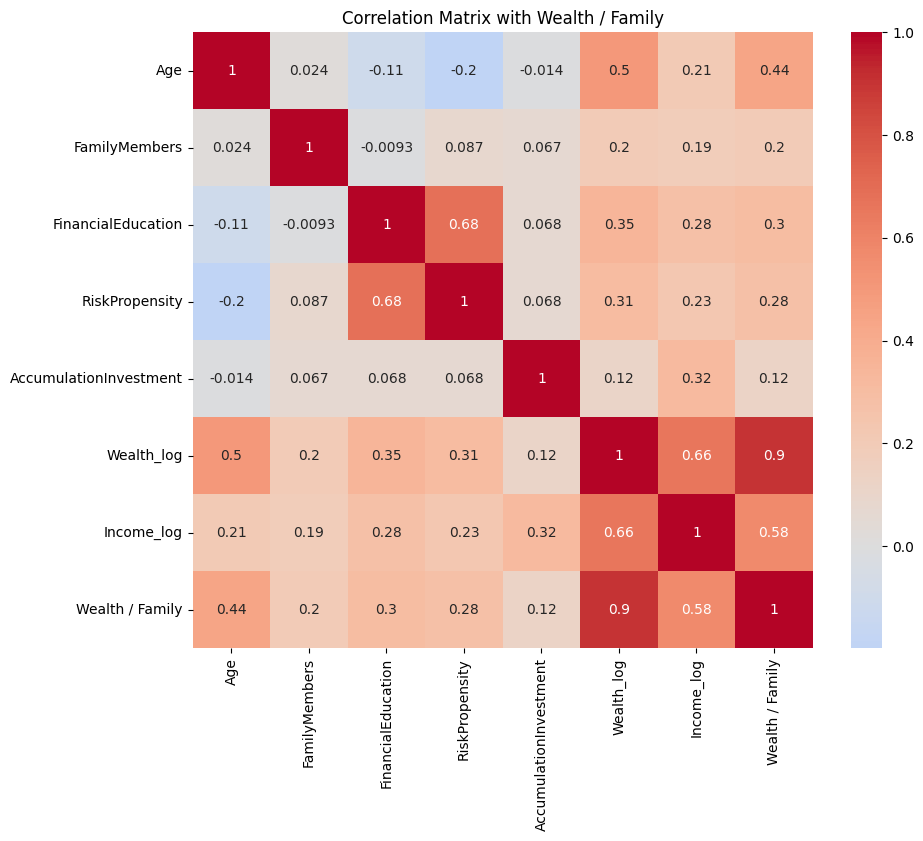

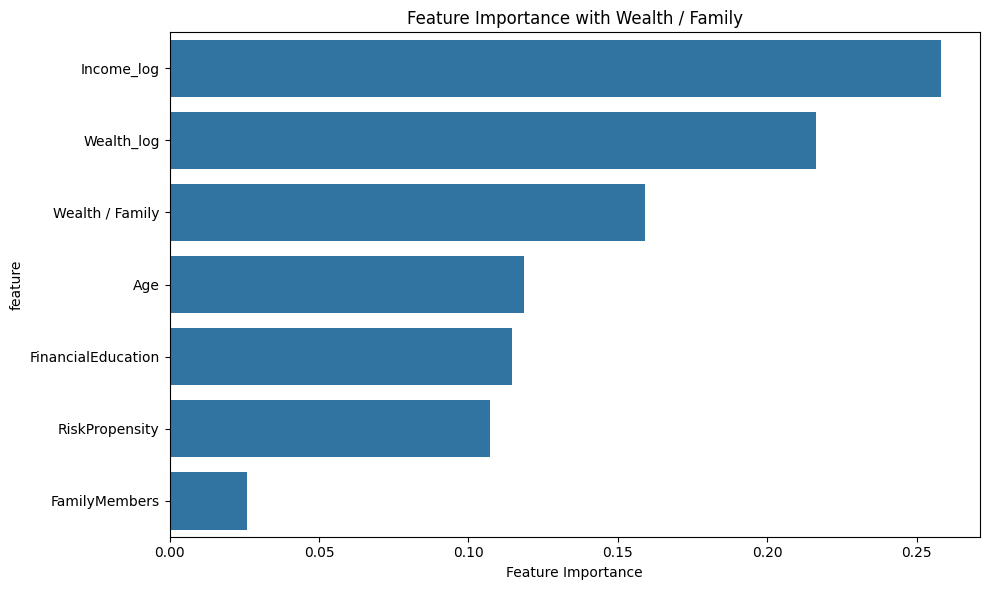

Results for Wealth / Family: {'new_feature': 'Wealth / Family', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.12302037740861334, 'mutual_information': 0.028359407612323695, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8537093386413261, 'auc_improvement': 0.003993999684383298, 'shap_importance': array([0.06965203, 0.06965203])}}
Feature Engineering Test Results for Income / Family:


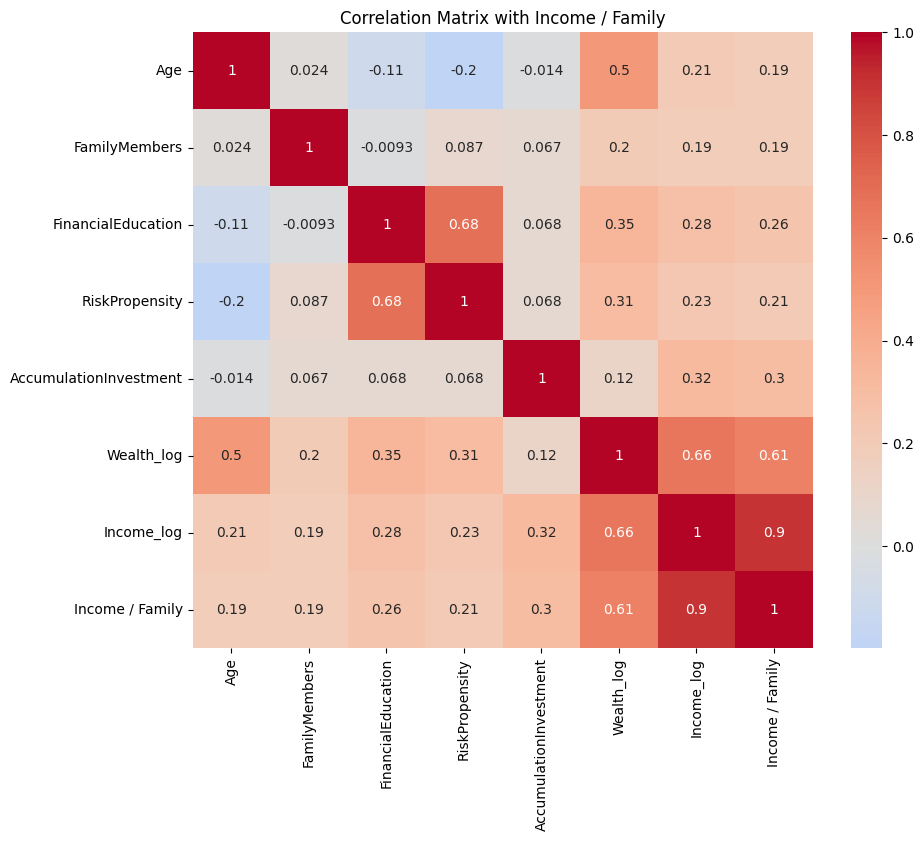

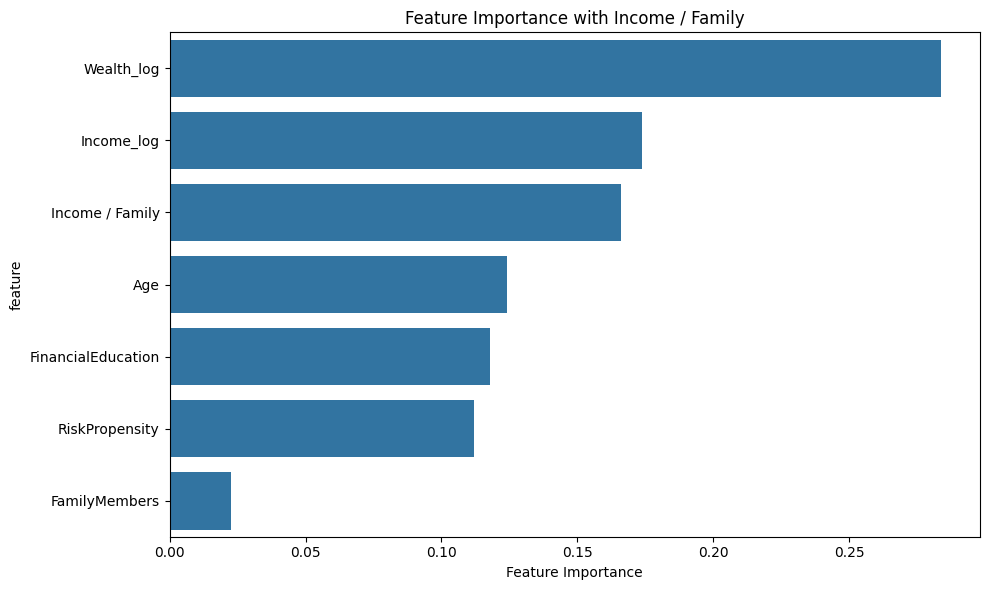

Results for Income / Family: {'new_feature': 'Income / Family', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.30122348375559677, 'mutual_information': 0.058662400552817795, 'auc_base': 0.8497153389569428, 'auc_with_new_feature': 0.8480049305375397, 'auc_improvement': -0.0017104084194031755, 'shap_importance': array([0.08460108, 0.08460108])}}


In [23]:
for name, df in zip(new_feature_names, datasets_with_new_features):
    result = test_feature_engineering(df, new_feature=name, target='AccumulationInvestment', threshold_corr=0.1, threshold_mi=0.01, threshold_auc=0.01)
    print(f"Results for {name}: {result}")

## Income Investment

In [26]:
df_income = needs_df.copy()
df_income = df_income.drop(columns=['AccumulationInvestment'])
df_income.head()

Age  FamilyMembers  FinancialEducation  RiskPropensity  \
0  0.396525              2           -1.258110       -0.855883   
1  1.900222              2           -0.397747       -1.269115   
2 -1.859021              2           -0.671259       -0.747694   
3  1.148373              4            2.302746        1.931786   
4  0.229447              3            0.070007       -0.090315   

   IncomeInvestment  Wealth_log  Income_log  
0                 0   -0.205413    0.294165  
1                 1    0.833019   -1.030406  
2                 0    0.036981   -0.974190  
3                 1    2.059078    2.005276  
4                 0   -0.093922   -1.055129

In [27]:
df_income.corr(numeric_only=True)[['IncomeInvestment']]

IncomeInvestment
Age                         0.334249
FamilyMembers               0.041936
FinancialEducation          0.087424
RiskPropensity              0.063324
IncomeInvestment            1.000000
Wealth_log                  0.403812
Income_log                  0.212190

In [29]:
# Create the two lists
datasets_with_new_features = []
new_feature_names = []

# Generate datasets
for feature_name, creation_func in feature_combinations.items():
    # Copy original data to avoid modifying it
    df_copy = df_income.copy()
    # Add the new feature
    df_copy[feature_name] = creation_func(df_copy)
    # Append to lists
    datasets_with_new_features.append(df_copy)
    new_feature_names.append(feature_name)

# Verification
print("New feature names:", new_feature_names)
print("\nFirst dataset with feature", new_feature_names[0], ":")
datasets_with_new_features[1].head()

New feature names: ['Age * RiskPropensity', 'Age * FinancialEducation', 'Age * Wealth_log', 'RiskPropensity * FinancialEducation', 'RiskPropensity * Wealth_log', 'FinancialEducation * Wealth_log', 'FinancialEducation * Income_log', 'Income_log * Wealth_log', 'Income / Wealth', 'Age / Wealth', 'Edu / Risk', 'Wealth / Family', 'Income / Family']

First dataset with feature Age * RiskPropensity :


Age  FamilyMembers  FinancialEducation  RiskPropensity  \
0  0.396525              2           -1.258110       -0.855883   
1  1.900222              2           -0.397747       -1.269115   
2 -1.859021              2           -0.671259       -0.747694   
3  1.148373              4            2.302746        1.931786   
4  0.229447              3            0.070007       -0.090315   

   IncomeInvestment  Wealth_log  Income_log  Age * FinancialEducation  
0                 0   -0.205413    0.294165                 -0.498872  
1                 1    0.833019   -1.030406                 -0.755808  
2                 0    0.036981   -0.974190                  1.247884  
3                 1    2.059078    2.005276                  2.644413  
4                 0   -0.093922   -1.055129                  0.016063

Feature Engineering Test Results for Age * RiskPropensity:


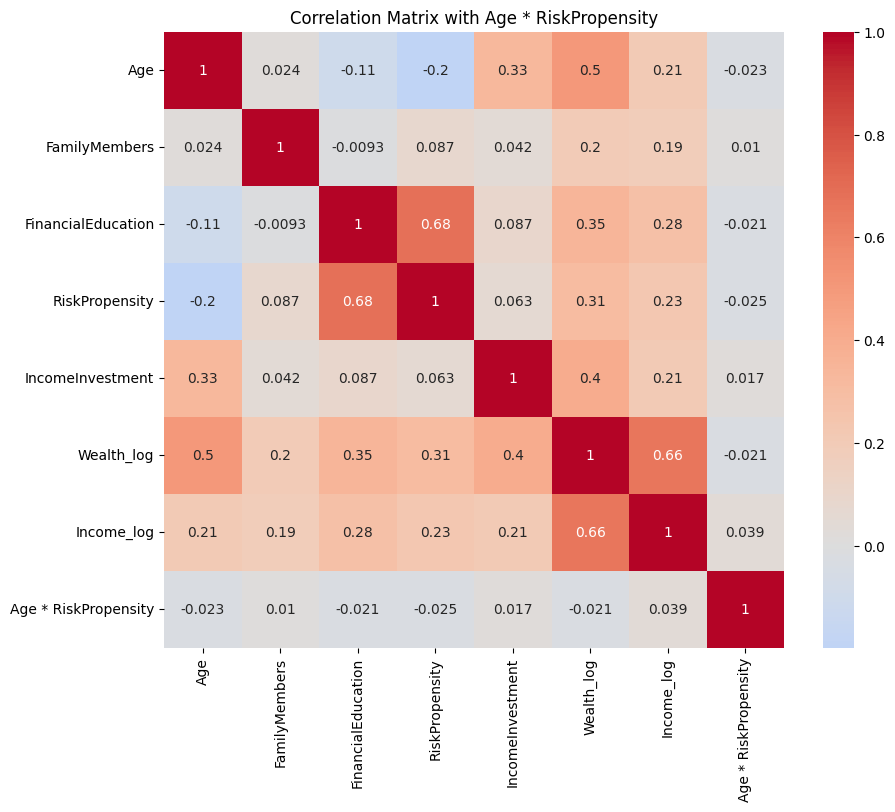

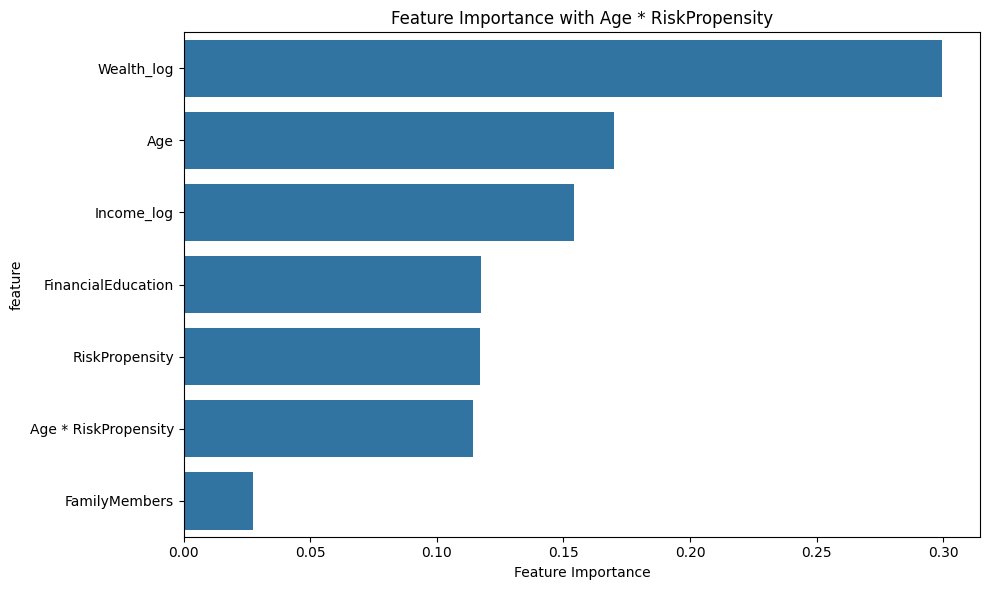

Results for Age * RiskPropensity: {'new_feature': 'Age * RiskPropensity', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.016859961941797466, 'mutual_information': 0.01231968762790392, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7912863832017039, 'auc_improvement': -0.004961172768381039, 'shap_importance': array([0.03177573, 0.03177573])}}
Feature Engineering Test Results for Age * FinancialEducation:


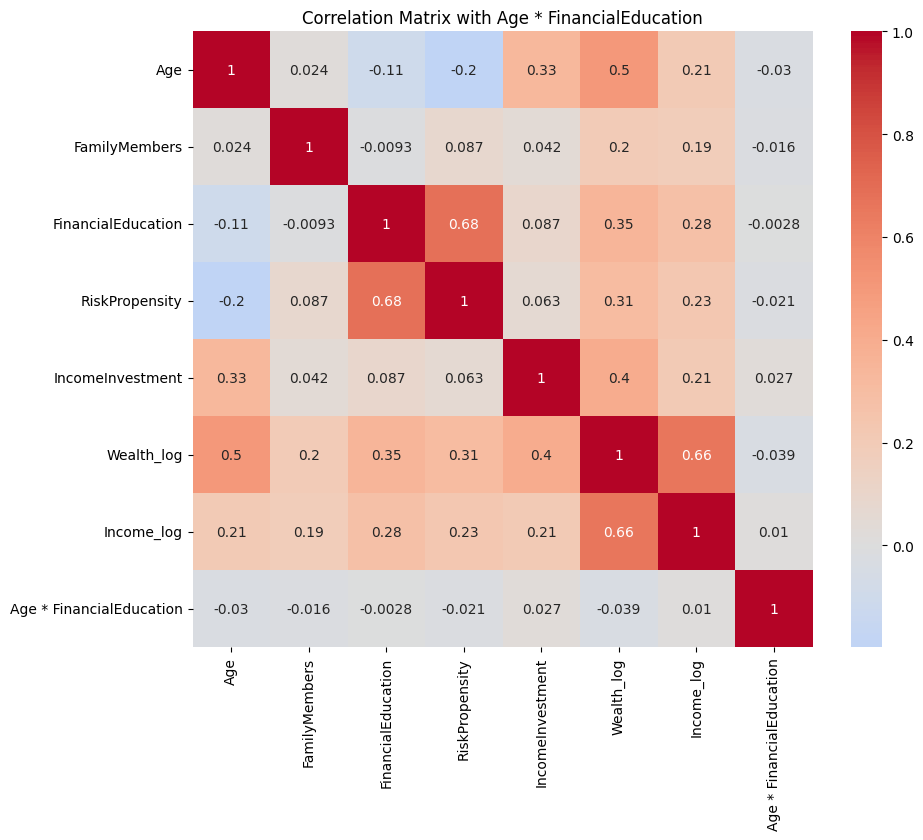

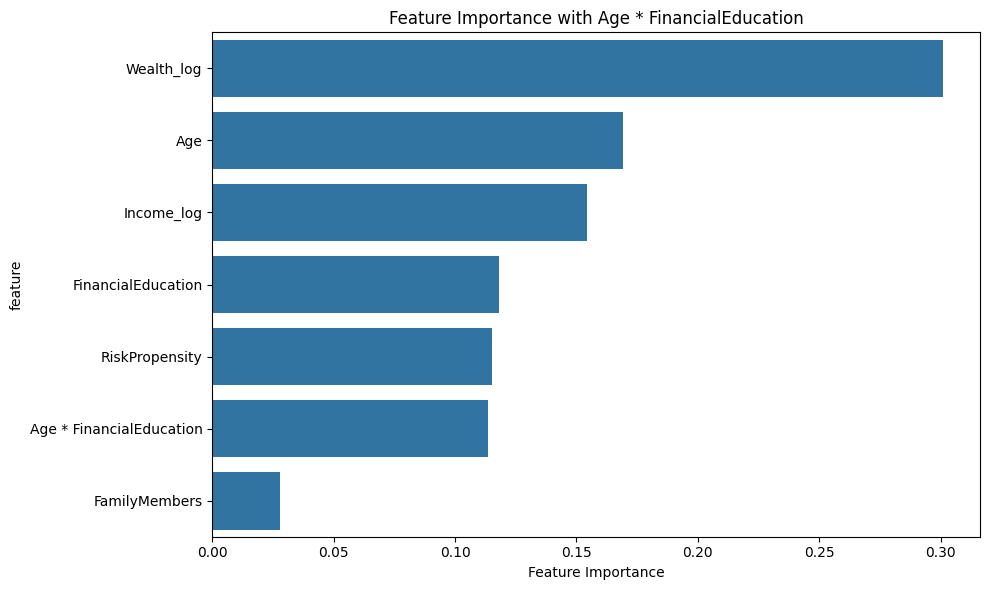

Results for Age * FinancialEducation: {'new_feature': 'Age * FinancialEducation', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.02673918568672373, 'mutual_information': 0.01804141052513164, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7879338841791882, 'auc_improvement': -0.008313671790896704, 'shap_importance': array([0.03211037, 0.03211037])}}
Feature Engineering Test Results for Age * Wealth_log:


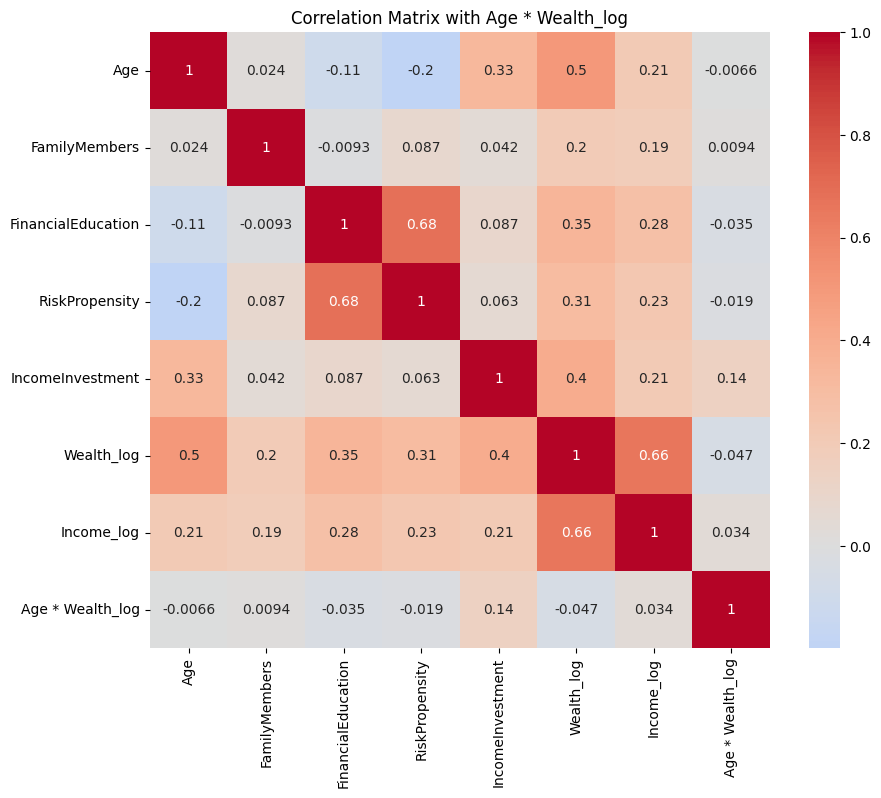

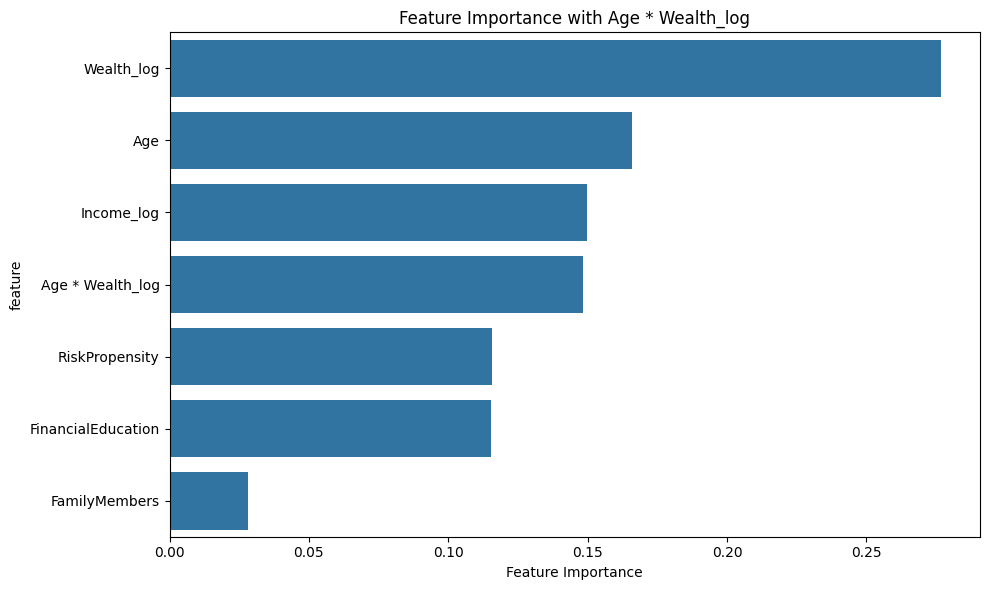

Results for Age * Wealth_log: {'new_feature': 'Age * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.14372552799386729, 'mutual_information': 0.03439185341986817, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7868834426503457, 'auc_improvement': -0.009364113319739187, 'shap_importance': array([0.05466317, 0.05466317])}}
Feature Engineering Test Results for RiskPropensity * FinancialEducation:


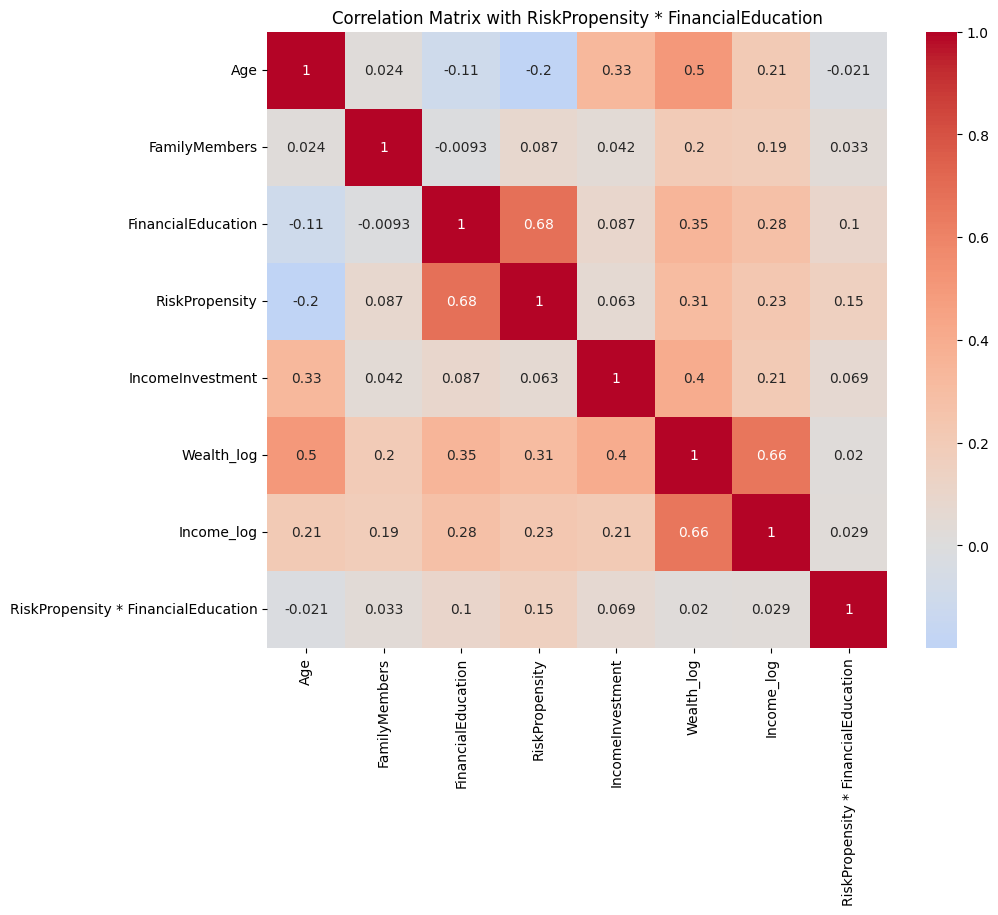

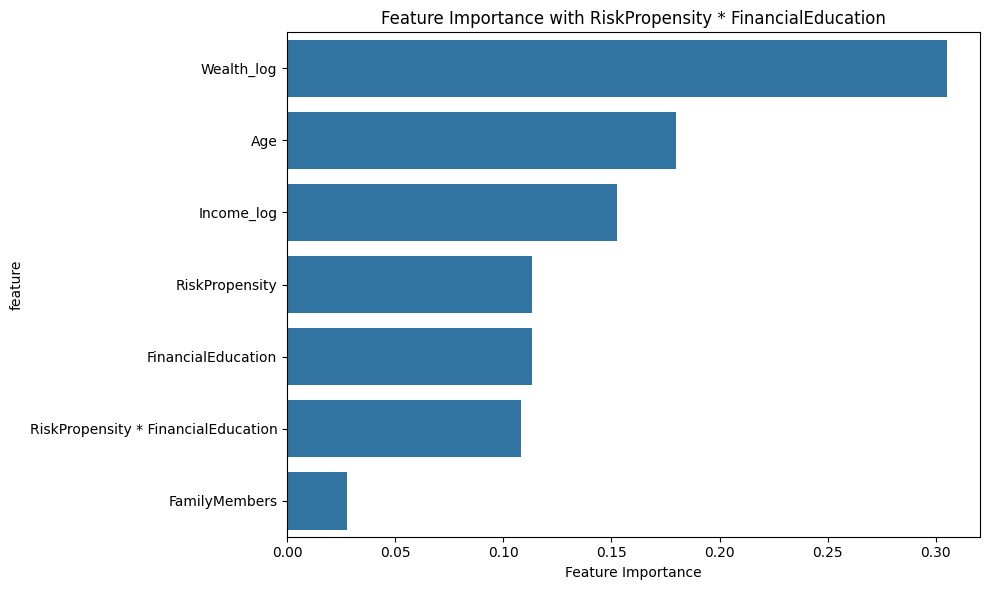

Results for RiskPropensity * FinancialEducation: {'new_feature': 'RiskPropensity * FinancialEducation', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.06857133094357017, 'mutual_information': 0.007589430076692993, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7955031052539588, 'auc_improvement': -0.000744450716126055, 'shap_importance': array([0.02854913, 0.02854913])}}
Feature Engineering Test Results for RiskPropensity * Wealth_log:


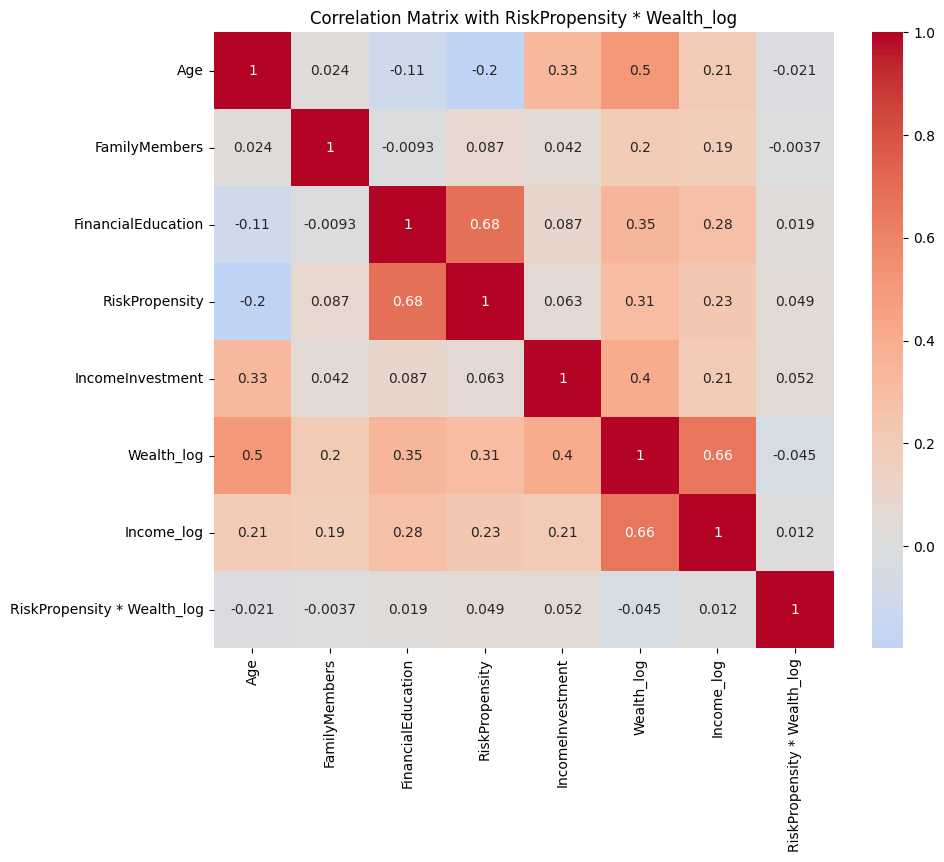

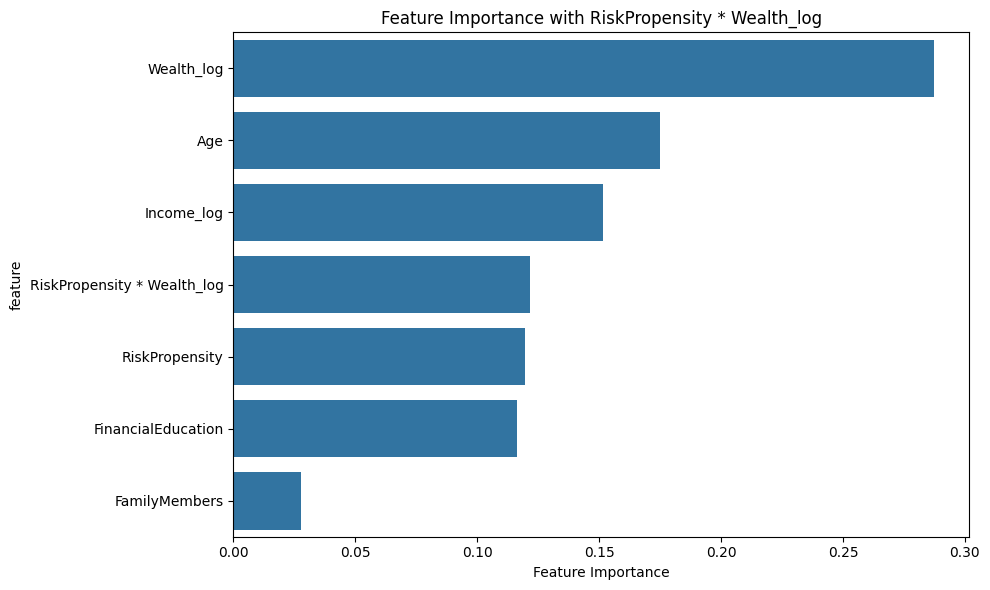

Results for RiskPropensity * Wealth_log: {'new_feature': 'RiskPropensity * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.051964482225219884, 'mutual_information': 0.015434552418074343, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7949630890093443, 'auc_improvement': -0.0012844669607405823, 'shap_importance': array([0.04231718, 0.04231718])}}
Feature Engineering Test Results for FinancialEducation * Wealth_log:


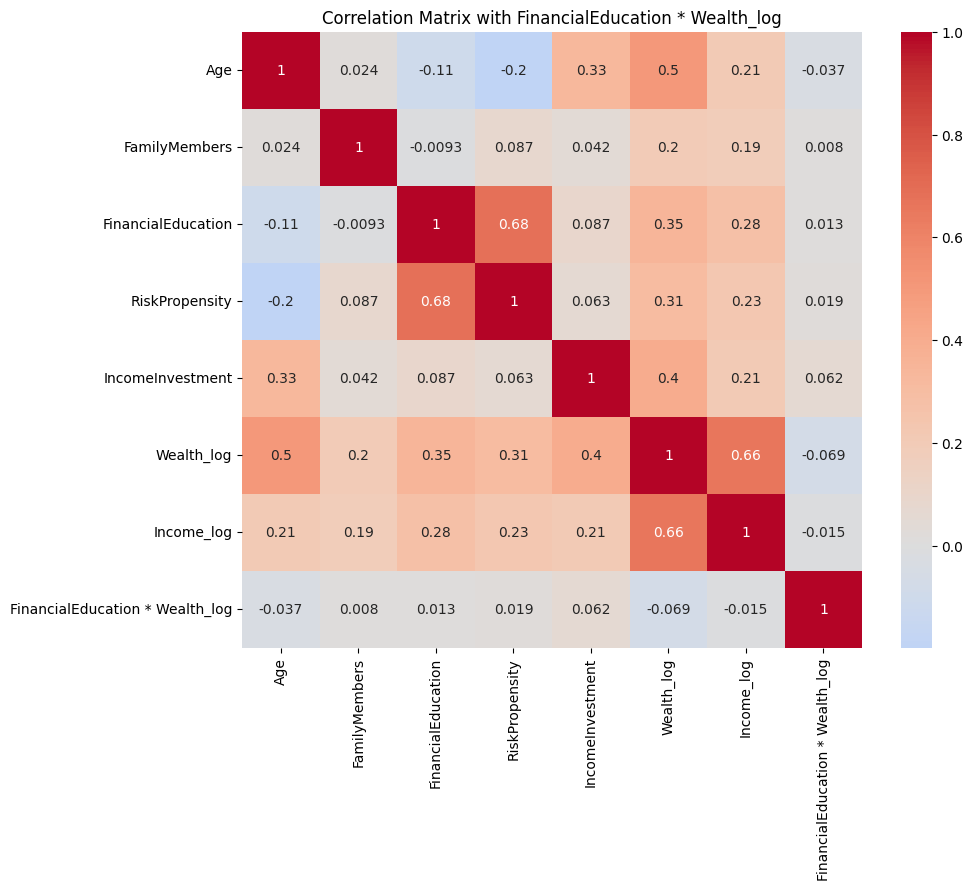

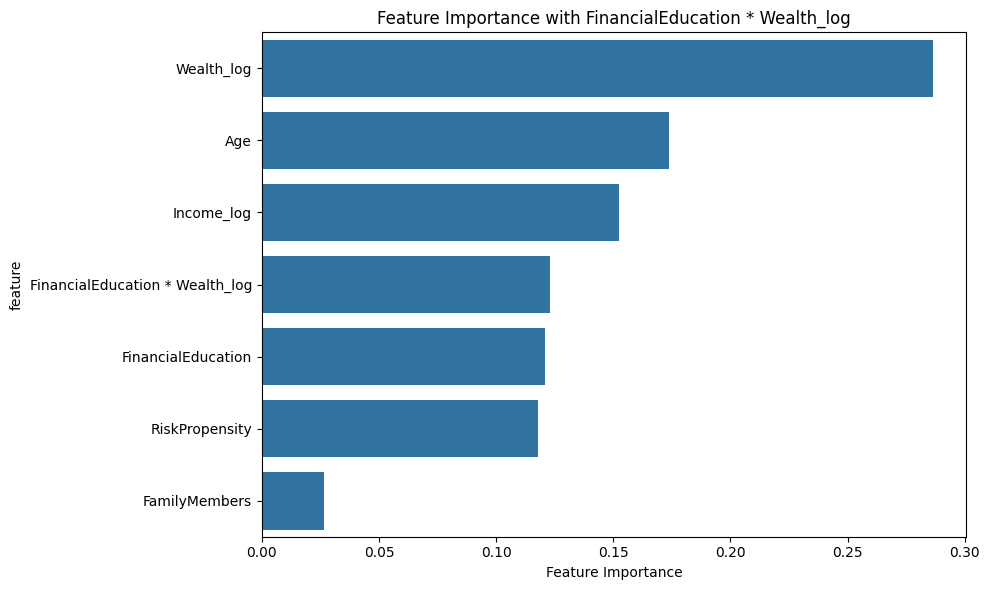

Results for FinancialEducation * Wealth_log: {'new_feature': 'FinancialEducation * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.062487367441432774, 'mutual_information': 0.03069229120278938, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7971535614969298, 'auc_improvement': 0.0009060055268449441, 'shap_importance': array([0.04121361, 0.04121361])}}
Feature Engineering Test Results for FinancialEducation * Income_log:


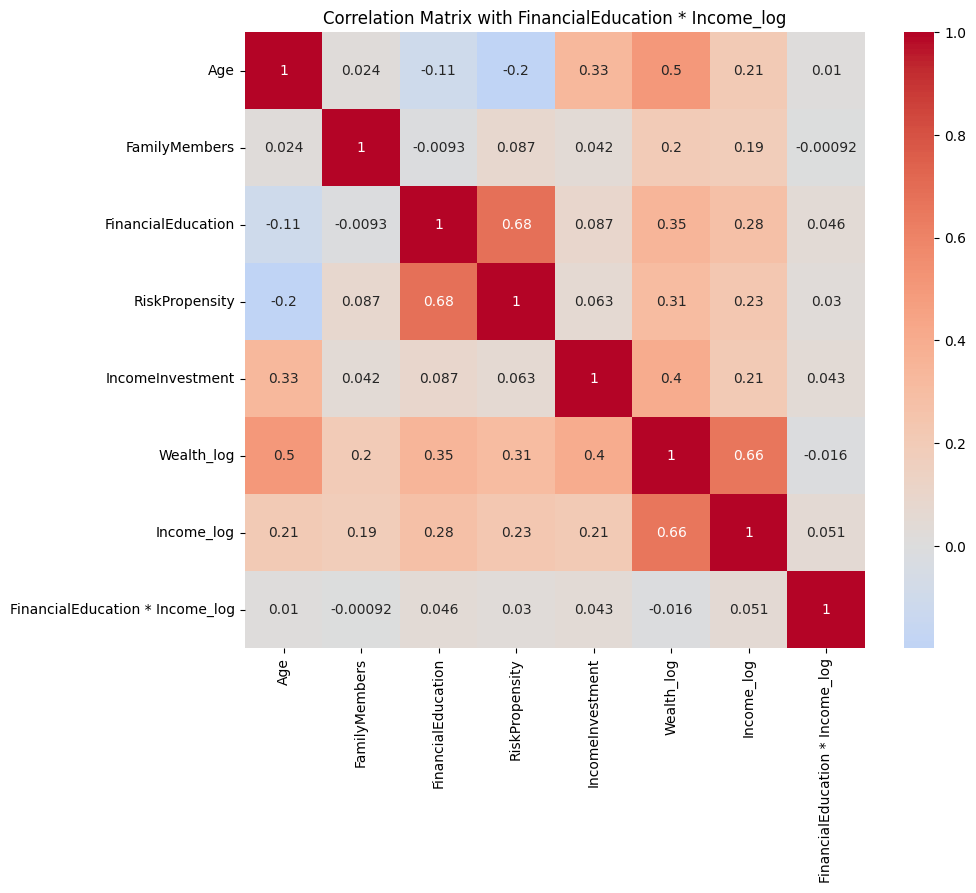

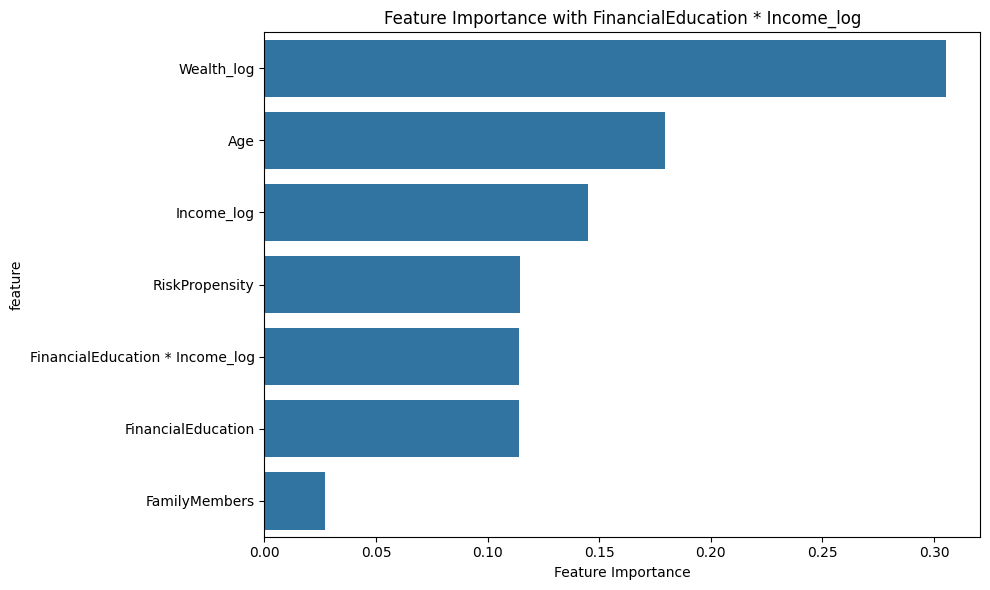

Results for FinancialEducation * Income_log: {'new_feature': 'FinancialEducation * Income_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.04297970464450453, 'mutual_information': 0, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7959839961129691, 'auc_improvement': -0.00026355985711579155, 'shap_importance': array([0.0322362, 0.0322362])}}
Feature Engineering Test Results for Income_log * Wealth_log:


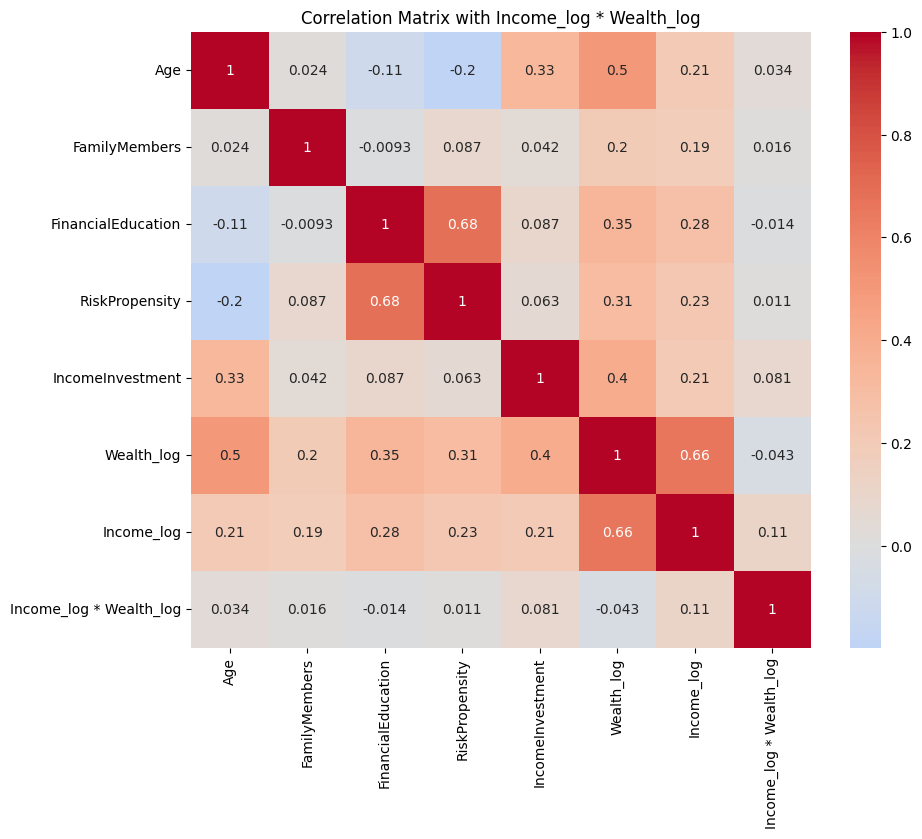

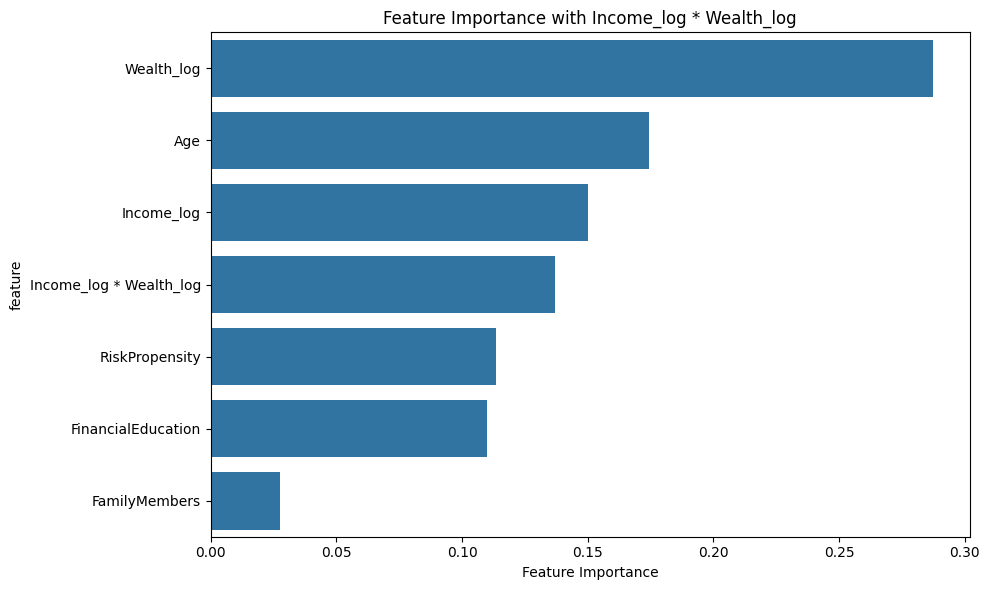

Results for Income_log * Wealth_log: {'new_feature': 'Income_log * Wealth_log', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.0807060812731906, 'mutual_information': 0.012579066770237235, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.792213132627331, 'auc_improvement': -0.0040344233427539455, 'shap_importance': array([0.04601183, 0.04601183])}}
Feature Engineering Test Results for Income / Wealth:


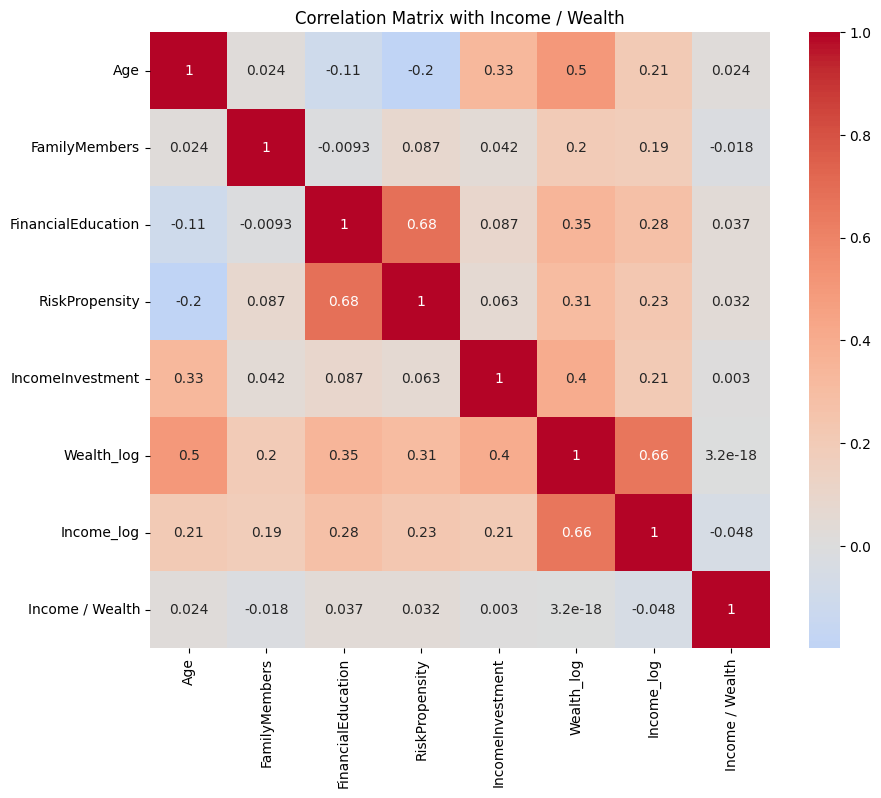

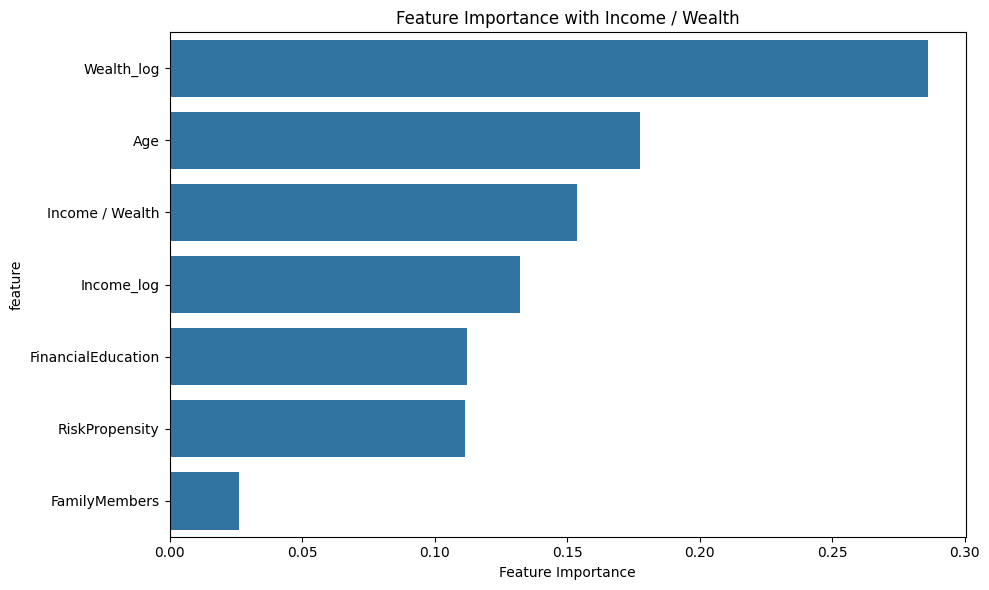

Results for Income / Wealth: {'new_feature': 'Income / Wealth', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.0030261078962492997, 'mutual_information': 0.017558116773125132, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7939543406666387, 'auc_improvement': -0.002293215303446172, 'shap_importance': array([0.0566434, 0.0566434])}}
Feature Engineering Test Results for Age / Wealth:


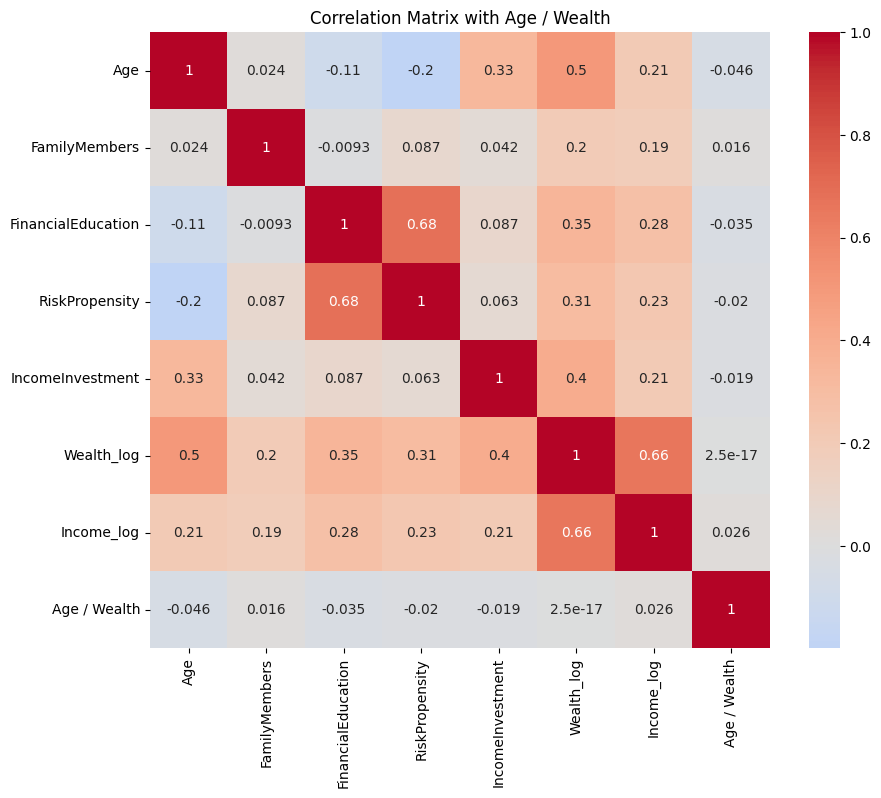

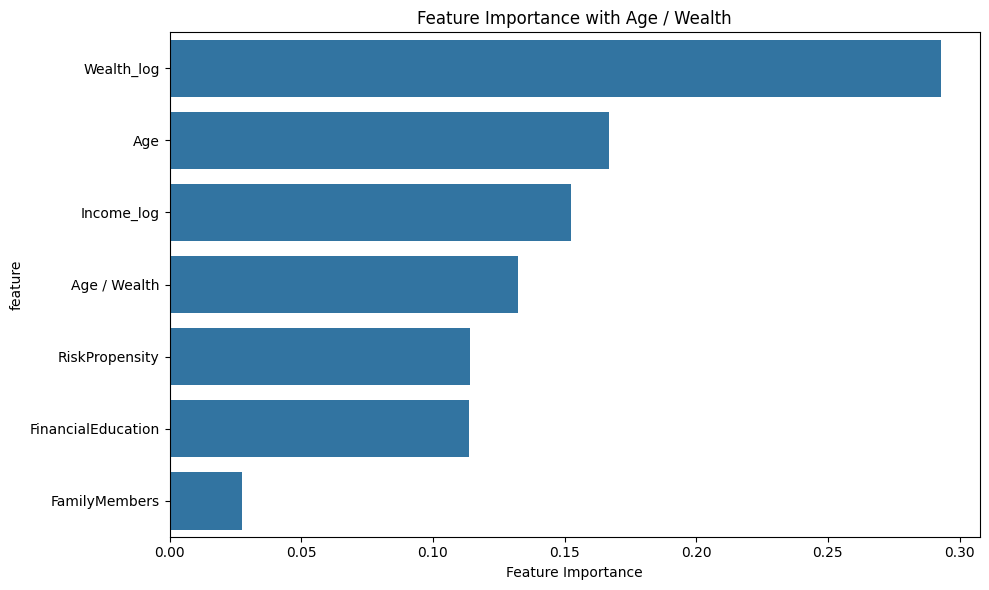

Results for Age / Wealth: {'new_feature': 'Age / Wealth', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': -0.018696533662259006, 'mutual_information': 0.020353914755955715, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7859009710891937, 'auc_improvement': -0.01034658488089124, 'shap_importance': array([0.04224908, 0.04224908])}}
Feature Engineering Test Results for Edu / Risk:


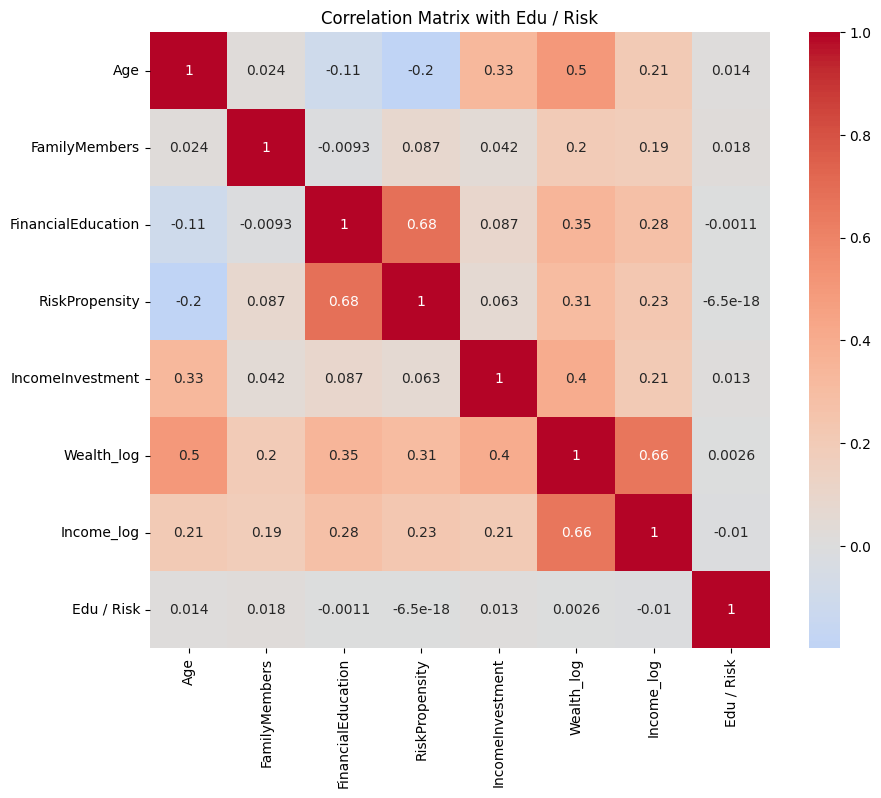

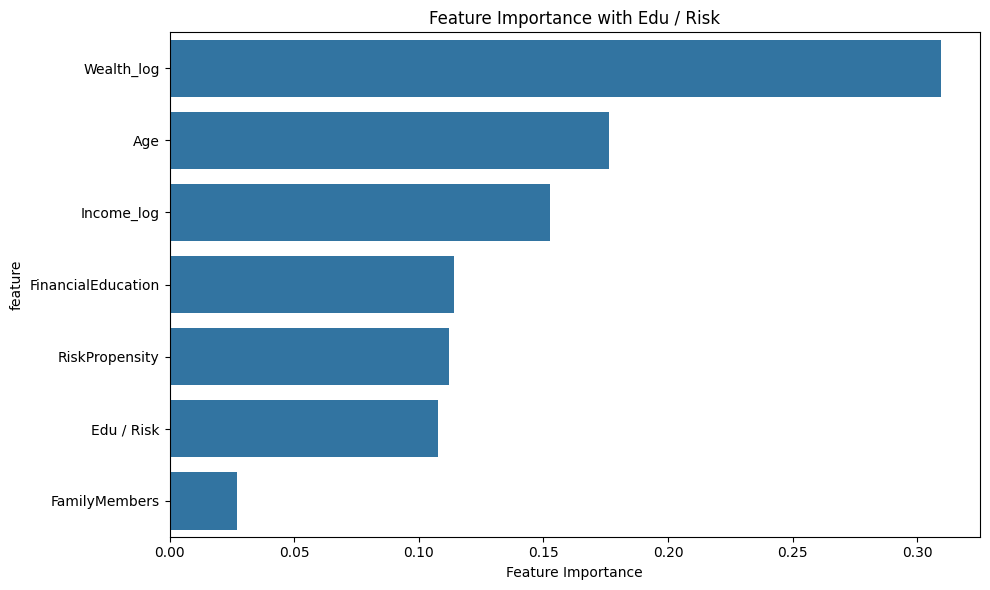

Results for Edu / Risk: {'new_feature': 'Edu / Risk', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.0133882827306406, 'mutual_information': 0.003000523386403442, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.793038954666849, 'auc_improvement': -0.0032086013032358585, 'shap_importance': array([0.02747556, 0.02747556])}}
Feature Engineering Test Results for Wealth / Family:


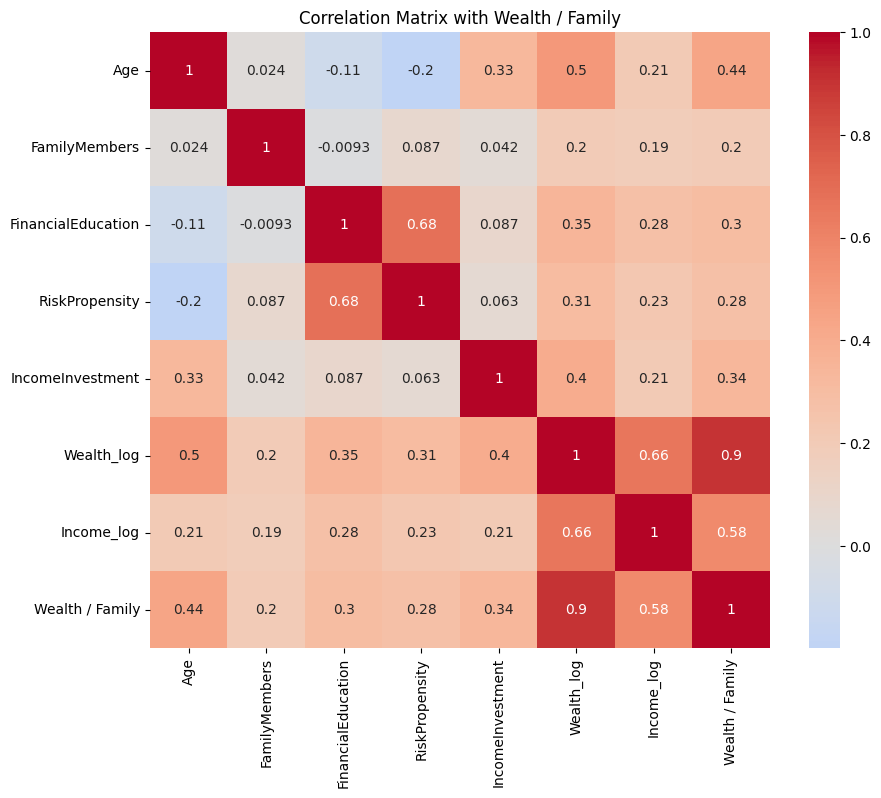

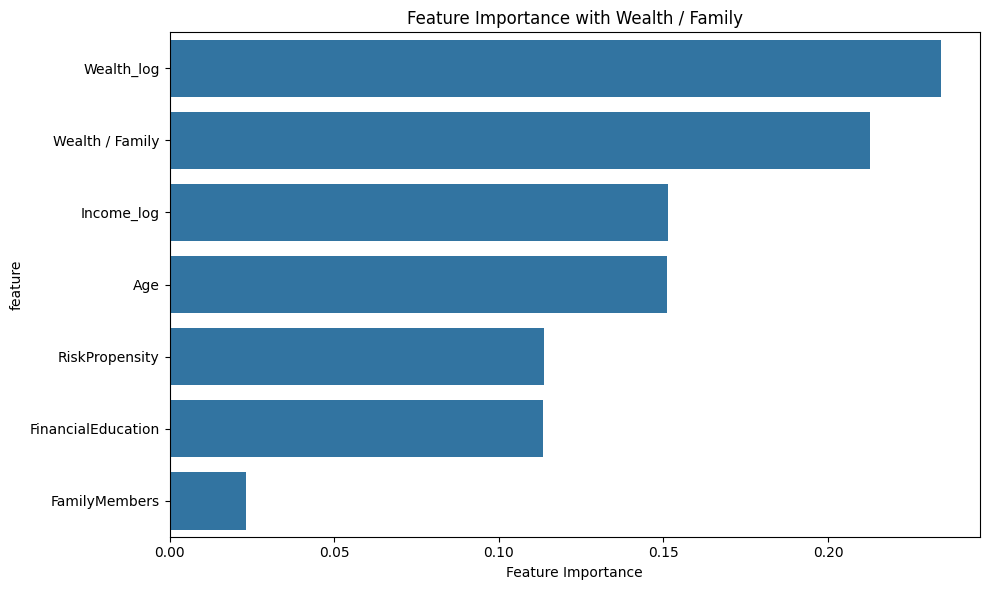

Results for Wealth / Family: {'new_feature': 'Wealth / Family', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.3369616170555471, 'mutual_information': 0.13024789450388674, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7932123138444478, 'auc_improvement': -0.0030352421256371054, 'shap_importance': array([0.09697768, 0.09697768])}}
Feature Engineering Test Results for Income / Family:


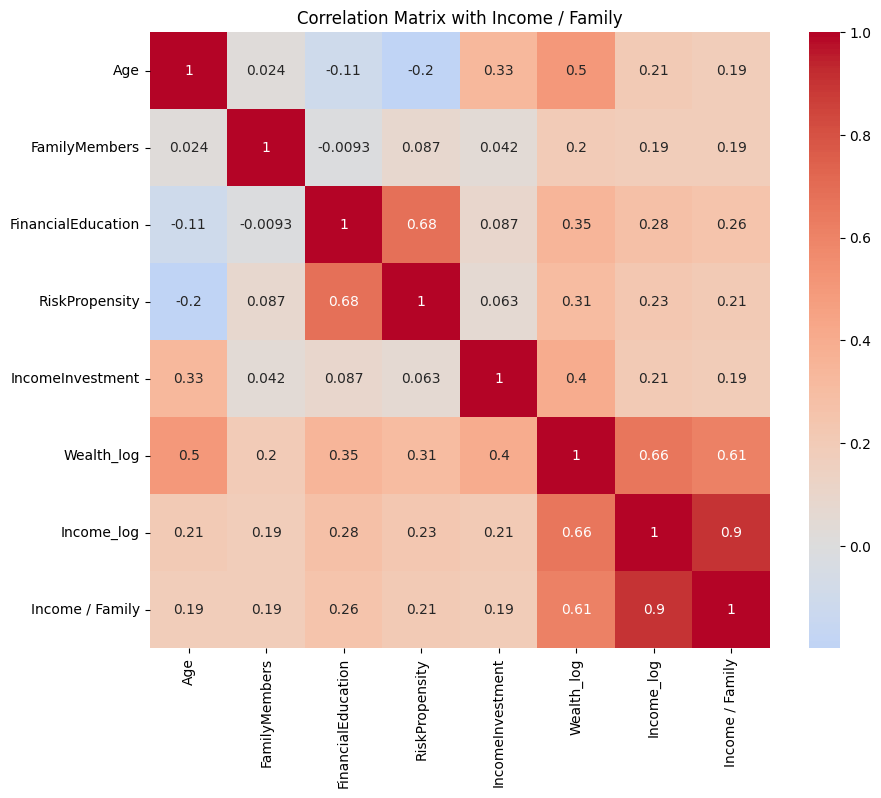

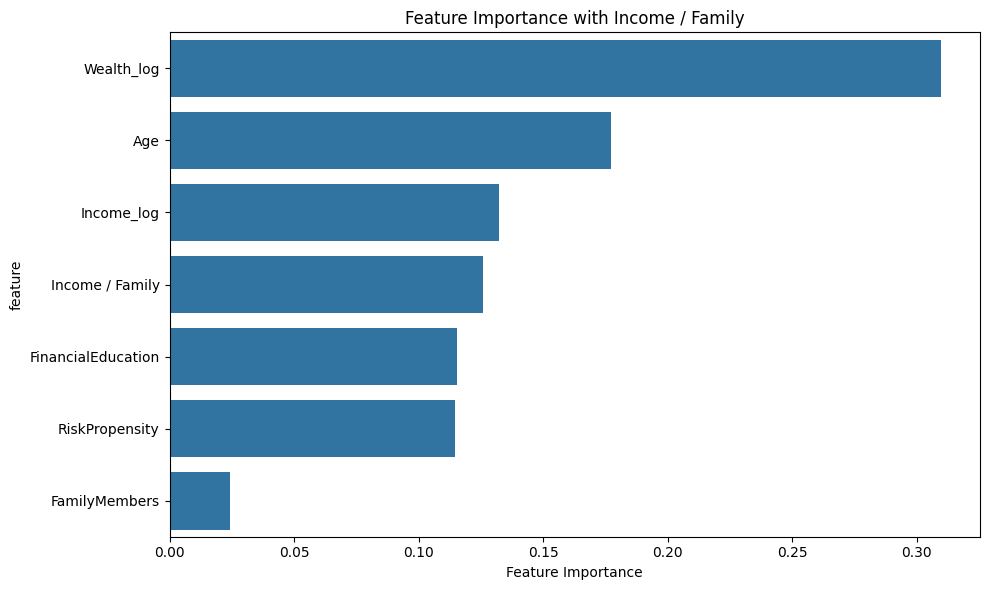

Results for Income / Family: {'new_feature': 'Income / Family', 'keep_feature': False, 'recommendation': '', 'details': {'correlation_with_target': 0.19159967990212978, 'mutual_information': 0.00465044627197142, 'auc_base': 0.7962475559700849, 'auc_with_new_feature': 0.7966796263832676, 'auc_improvement': 0.0004320704131827169, 'shap_importance': array([0.04189682, 0.04189682])}}


In [30]:
for name, df in zip(new_feature_names, datasets_with_new_features):
    result = test_feature_engineering(df, new_feature=name, target='IncomeInvestment', threshold_corr=0.1, threshold_mi=0.01, threshold_auc=0.01)
    print(f"Results for {name}: {result}")